# Project Assignment

**1)** Description of the project.

**2a)** Description of the nonlinear system with its mathematical model.

**2b)** Definition of states, control inputs, and considered disturbances.

**3a)** Selection of the operating point(s) and linearization of the system.

**3b)** Verification of the controllability of the linearized model.

**4)** Design of an infinite-horizon LQR controller for system stabilization.

**5)** Either (a) formulation of the MPC stabilization problem with input/state constraints or (b) design of a finite-horizon LQR controller for trajectory planning.

**6)** Simulation of nonlinear system control (a) without and (b) with disturbances.

**7)** Conclusion.

# Imports

In [1]:
import importlib
import itertools
import math
import time
import typing as T
import warnings
from collections import namedtuple

import control
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import sympy as smp
import sympy.matrices.dense  # type: ignore
import sympy.utilities.autowrap  # type: ignore
from IPython.display import Image
from scipy.linalg import solve_discrete_are

import helpers

importlib.reload(helpers)
from helpers import GRAVITY, HALF, discretization_by_rk4_integration, plot, plot2, print2, print_array, rk4

# 1) System Description

A pendulum (pole) on a cart that can move horizontally and vertically. Both the cart and the pendulum are simplified to point masses. The cart is controlled by horizontal and vertical forces.

The goal is to design a controller that can balance the pendulum in inverted position and follow a reference for for the horizontal and vertical position of the cart.

**Inputs**: horizontal force $f_x$ and vertical force $f_y$.

**Disturbances**: horizontal force offset $\Delta f_x$ and vertical force offset $\Delta f_y$.

**States**: cart's position $x_c$, $y_c$, pendulum's rotation $\alpha$ and their speeds $v_{xc} = \dot{x}_c$, $v_{yc} = \dot{y}_c$, $\omega = \dot{\alpha}$.

**Outputs**: all state variables.

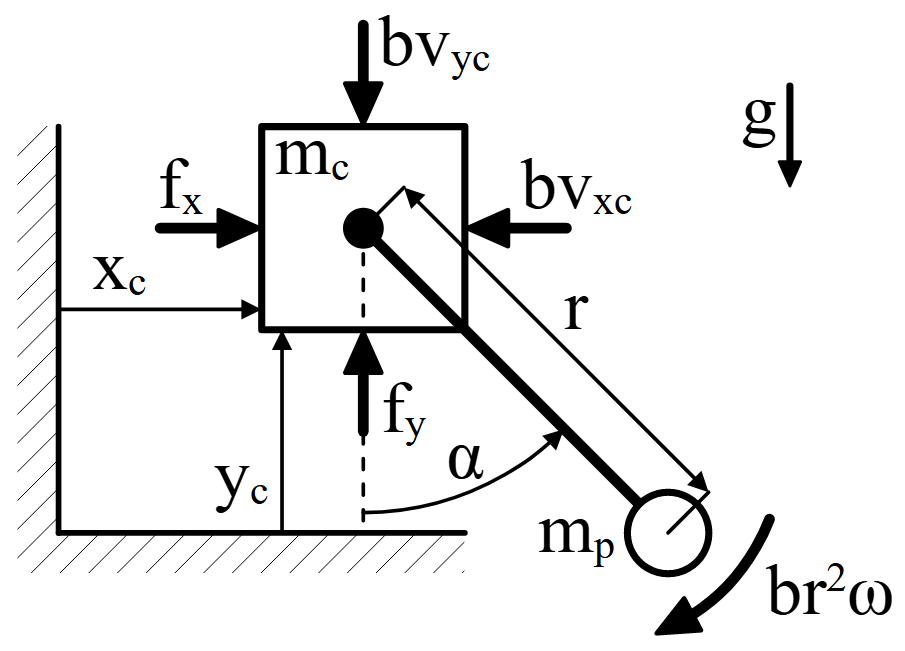

In [2]:
Image(filename="diagram/diagram.png", width=500)

# 2) Dynamics Derivation

## Symbolic Variables

In [3]:
t, g, m_c, m_p, r, b = smp.symbols("t g m_c m_p r b", real=True, positive=True)
print2("constants", t, g, m_c, m_p, r, b)

constants = {
    g: GRAVITY,  # m/s^2
    m_c: smp.Rational("0.5"),  # kg
    m_p: smp.Rational("0.2"),  # kg
    r: smp.Rational("0.4"),  # m
    b: smp.Rational("0.1"),  # N/m/s
}

x_c, y_c, alpha = (f(t) for f in smp.symbols("x_c y_c alpha", real=True, cls=smp.Function))
print2("generalized (independent) coordinates", x_c, y_c, alpha)

x_p = x_c + r * smp.sin(alpha)
y_p = y_c - r * smp.cos(alpha)
print2("dependent coordinates", x_p, y_p)

f_x, f_y = smp.symbols("f_x f_y", real=True)
print2("control forces", f_x, f_y)

dx_c, dy_c, dx_p, dy_p, dalpha = (smp.diff(f, t) for f in (x_c, y_c, x_p, y_p, alpha))
print2("velocities", dx_c, dy_c, dx_p, dy_p, dalpha)

ddx_c, ddy_c, ddalpha = (smp.diff(f, t) for f in (dx_c, dy_c, dalpha))
print2("accelerations", ddx_c, ddy_c, ddalpha)

ssx = smp.symbols("x1 x2 x3 x4 x5 x6", real=True)
ssu = smp.symbols("u1 u2", real=True)
print2("state variables", *ssx)
print2("control inputs", *ssu)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Energy and Forces

$$
\begin{aligned}
E_k &=
\dfrac{1}{2} m_c \left( \dot{x}_c^2 + \dot{y}_c^2 \right) +
\dfrac{1}{2} m_p \left( \dot{x}_p^2 + \dot{y}_p^2 \right) \\
E_p &=
m_c g y_c +
m_p g y_p
\end{aligned}
$$

$$
\begin{aligned}
Q_{x_c} &= f_x - b \dot{x}_c \\
Q_{y_c} &= f_y - b \dot{y}_c \\
Q_{\alpha} &= - b r^2 \dot{\alpha}
\end{aligned}
$$

In [4]:
Ek = HALF * m_c * (dx_c**2 + dy_c**2) + HALF * m_p * (dx_p**2 + dy_p**2)  # type: ignore
print2("kinetic energy", Ek)

Ep = m_c * g * y_c + m_p * g * y_p
print2("potential energy", Ep)

Q_x_c = f_x - b * dx_c
Q_y_c = f_y - b * dy_c
Q_alpha = -b * r**2 * dalpha  # b_rot = b * r**2
print2("generalized forces", Q_x_c, Q_y_c, Q_alpha)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Langrange Equations

$$
\mathcal{L} = E_k - E_p
$$

$$
\dfrac{\text{d}}{\text{d}t}\dfrac{\partial \mathcal{L}}{\partial \dot{q}} -
\dfrac{\partial \mathcal{L}}{\partial q} = Q, \quad \forall q
$$

In [5]:
L = Ek - Ep
eom_x_c = smp.Eq(smp.diff(smp.diff(L, dx_c), t) - smp.diff(L, x_c), Q_x_c)  # type: ignore
eom_y_c = smp.Eq(smp.diff(smp.diff(L, dy_c), t) - smp.diff(L, y_c), Q_y_c)  # type: ignore
eom_alpha = smp.Eq(smp.diff(smp.diff(L, dalpha), t) - smp.diff(L, alpha), Q_alpha)  # type: ignore
print2("lagrange equations", eom_x_c, eom_y_c, eom_alpha, newline=True)

<IPython.core.display.Latex object>

## Nonlinear Equations of Motion

In [6]:
_ = smp.solve(
    (eom_x_c, eom_y_c, eom_alpha),
    (ddx_c, ddy_c, ddalpha),
)
eom = smp.Matrix(
    [
        [smp.simplify(_[ddx_c])],
        [smp.simplify(_[ddy_c])],
        [smp.simplify(_[ddalpha])],
    ]
)
print2("equations of motion", eom, newline=True)

<IPython.core.display.Latex object>

## Nonlinear State-Space Representation

In [7]:
ss_eom = smp.Matrix(
    [
        [dx_c],
        [dy_c],
        [dalpha],
        [eom[0, 0]],
        [eom[1, 0]],
        [eom[2, 0]],
    ]
)
ss_subs = {
    x_c: ssx[0],
    y_c: ssx[1],
    alpha: ssx[2],
    dx_c: ssx[3],
    dy_c: ssx[4],
    dalpha: ssx[5],
    f_x: ssu[0],
    f_y: ssu[1],
}
ss_subs_reversed = {key: ss_subs[key] for key in reversed(ss_subs)}
ss_eom = ss_eom.subs(ss_subs_reversed)
print2("state-space representation", ss_eom, newline=True)

<IPython.core.display.Latex object>

In [8]:
ss_eom_num = ss_eom.subs(constants)
print2("state-space representation", ss_eom_num, newline=True)

<IPython.core.display.Latex object>

## Equilibrium Analysis

In [9]:
u0_sym = smp.Matrix([[0], [g * (m_c + m_p)]])
u0_num = u0_sym.subs(constants)
print2("inputs", u0_sym, u0_num)

u0 = np.array(u0_num, dtype=np.float64)[:, 0]
print_array(u0)

<IPython.core.display.Latex object>

[0.    6.867]


In [10]:
_ = ss_eom.subs(
    {
        ssx[0]: 0,  # x_c
        ssx[1]: 0,  # y_c
        # ssx[2]: 0, # alpha
        ssx[3]: 0,  # dx_c
        ssx[4]: 0,  # dy_c
        ssx[5]: 0,  # dalpha
        ssu[0]: u0_sym[0, 0],  # f_x
        ssu[1]: u0_sym[1, 0],  # f_y
    }
)
_ = smp.simplify(_)  # compacts trig functions
print2(_)

<IPython.core.display.Latex object>

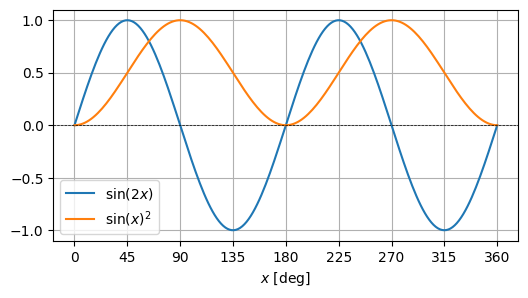

In [11]:
plt.figure(figsize=(6, 3))
_ = np.linspace(0, 2 * np.pi, 200)
plt.plot(np.rad2deg(_), np.sin(2 * _), label=r"$\sin(2x)$")
plt.plot(np.rad2deg(_), np.sin(_) ** 2, label=r"$\sin(x)^2$")
plt.axhline(0, color="black", lw=0.5, ls="--")
plt.xlabel(r"$x$ [deg]")
plt.xticks(np.arange(0, 361, 45))
plt.grid()
plt.legend()
plt.show()

## Callable Function

In [12]:
# https://docs.sympy.org/latest/modules/utilities/lambdify.html
_non_lin_dynamics = smp.lambdify(list(ss_subs.values()), ss_eom_num, modules="numpy")
print(_non_lin_dynamics)
print(_non_lin_dynamics.__doc__)


def non_lin_dynamics(
    x: npt.NDArray[np.float64],
    u: npt.NDArray[np.float64],
    t: float,
) -> npt.NDArray[np.float64]:
    return _non_lin_dynamics(*x, *u)[:, 0]


print_array(
    non_lin_dynamics(
        np.array([0, 0, math.radians(0), 0, 0, math.radians(0)]),
        np.array([0, 0]),
        0,
    )
)

<function _lambdifygenerated at 0x000001D909308E00>
Created with lambdify. Signature:

func(x1, x2, x3, x4, x5, x6, u1, u2)

Expression:

Matrix([[x4], [x5], [x6], [2*u1*cos(2*x3)/7 + 12*u1/7 + 2*u2*sin(2*x3)/7 -...

Source code:

def _lambdifygenerated(x1, x2, x3, x4, x5, x6, u1, u2):
    return array([[x4], [x5], [x6], [(2/7)*u1*cos(2*x3) + (12/7)*u1 + (2/7)*u2*sin(2*x3) - 1/35*x4*cos(2*x3) - 6/35*x4 - 1/35*x5*sin(2*x3) + (4/35)*x6**2*sin(x3) + (2/25)*x6*cos(x3)], [(2/7)*u1*sin(2*x3) - 2/7*u2*cos(2*x3) + (12/7)*u2 - 1/35*x4*sin(2*x3) + (1/35)*x5*cos(2*x3) - 6/35*x5 - 4/35*x6**2*cos(x3) + (2/25)*x6*sin(x3) - 981/100], [-5*u1*cos(x3) - 5*u2*sin(x3) + (1/2)*x4*cos(x3) + (1/2)*x5*sin(x3) - 7/10*x6]])


Imported modules:


[ 0.    0.    0.    0.   -9.81  0.  ]


In [13]:
# https://docs.sympy.org/latest/modules/utilities/autowrap.html
_non_lin_dynamics_c = sympy.utilities.autowrap.autowrap(
    expr=ss_eom_num,
    args=list(ss_subs.values()),
    language="C",
    backend="cython",
    tempdir=".autowrap",
)
print(_non_lin_dynamics_c)
print(_non_lin_dynamics_c.__doc__)


def non_lin_dynamics_c(
    x: npt.NDArray[np.float64],
    u: npt.NDArray[np.float64],
    t: float,
) -> npt.NDArray[np.float64]:
    return _non_lin_dynamics_c(*x, *u)[:, 0]


print_array(
    non_lin_dynamics_c(
        np.array([0, 0, math.radians(0), 0, 0, math.radians(0)]),
        np.array([0, 0]),
        0,
    )
)

<cyfunction autofunc_c at 0x000001D90B449080>
None
[ 0.    0.    0.    0.   -9.81  0.  ]


In [14]:
start = time.perf_counter_ns()
for i in range(1000):
    non_lin_dynamics(
        np.array([i / 1000, 0, math.radians(0), 0, 0, math.radians(0)]),
        np.array([i / 1000, 0]),
        i,
    )
print(f"non_lin_dynamics \t{(time.perf_counter_ns() - start) / 1e6:7.3f} ms")

start = time.perf_counter_ns()
for i in range(1000):
    non_lin_dynamics_c(
        np.array([i / 1000, 0, math.radians(0), 0, 0, math.radians(0)]),
        np.array([i / 1000, 0]),
        i,
    )
print(f"non_lin_dynamics_c \t{(time.perf_counter_ns() - start) / 1e6:7.3f} ms")

non_lin_dynamics 	 25.276 ms
non_lin_dynamics_c 	  5.053 ms


## Nonlinear Model Validation Against Simscape

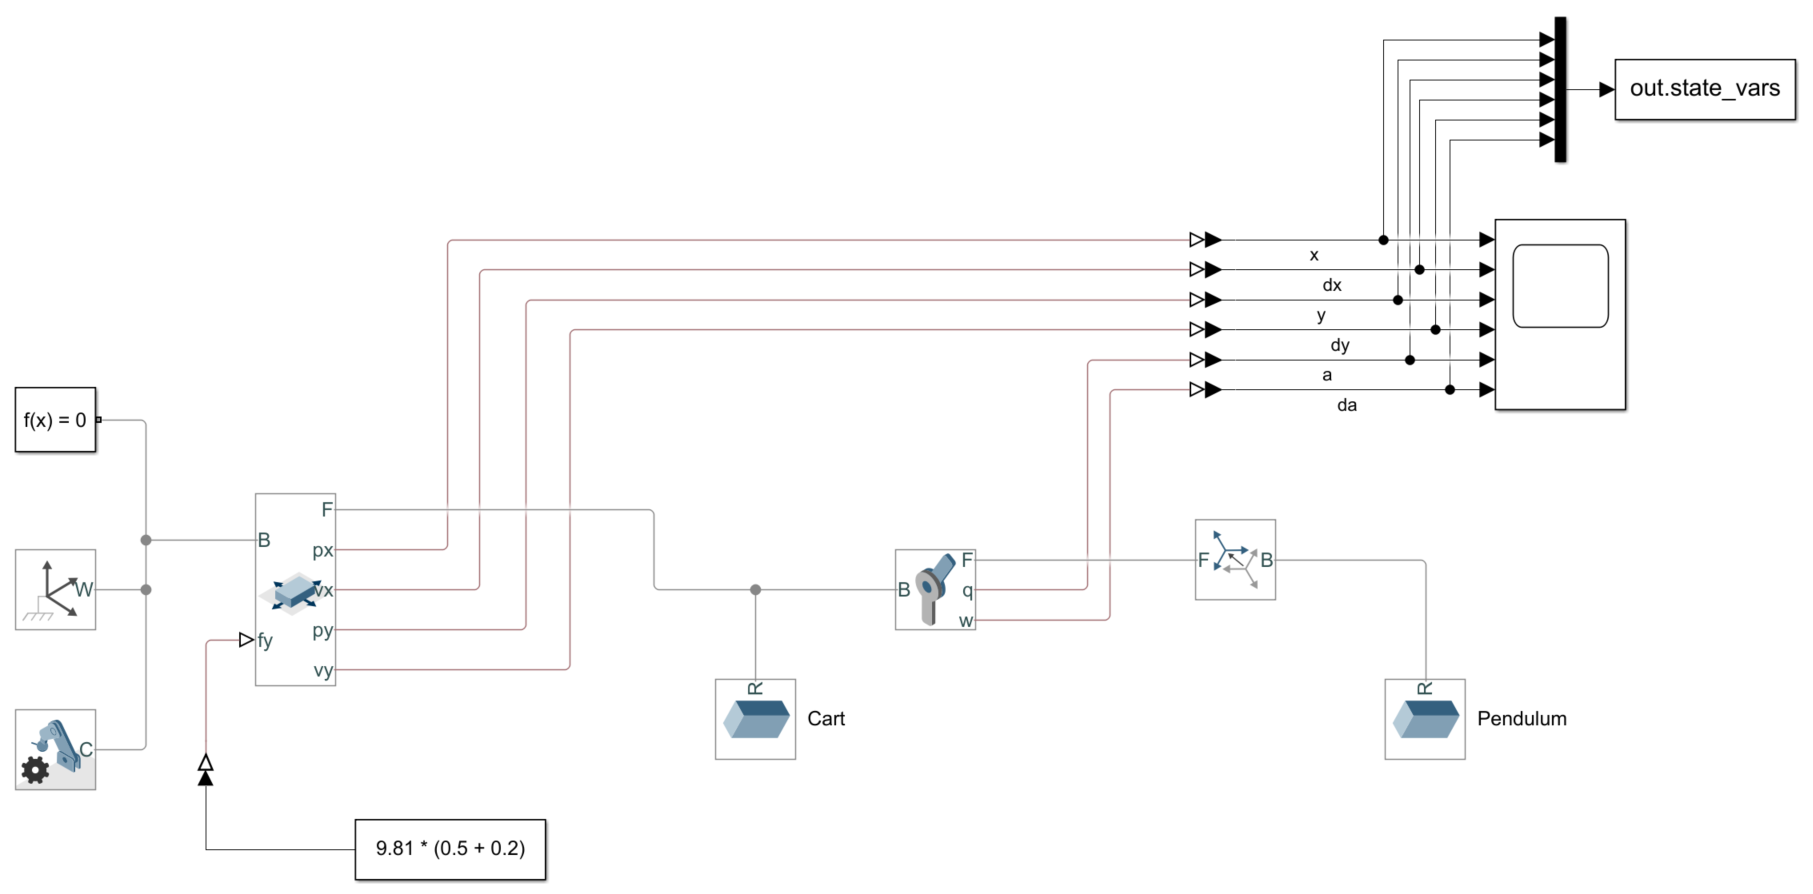

In [15]:
Image(filename="simscape/simscape.png", width=1000)

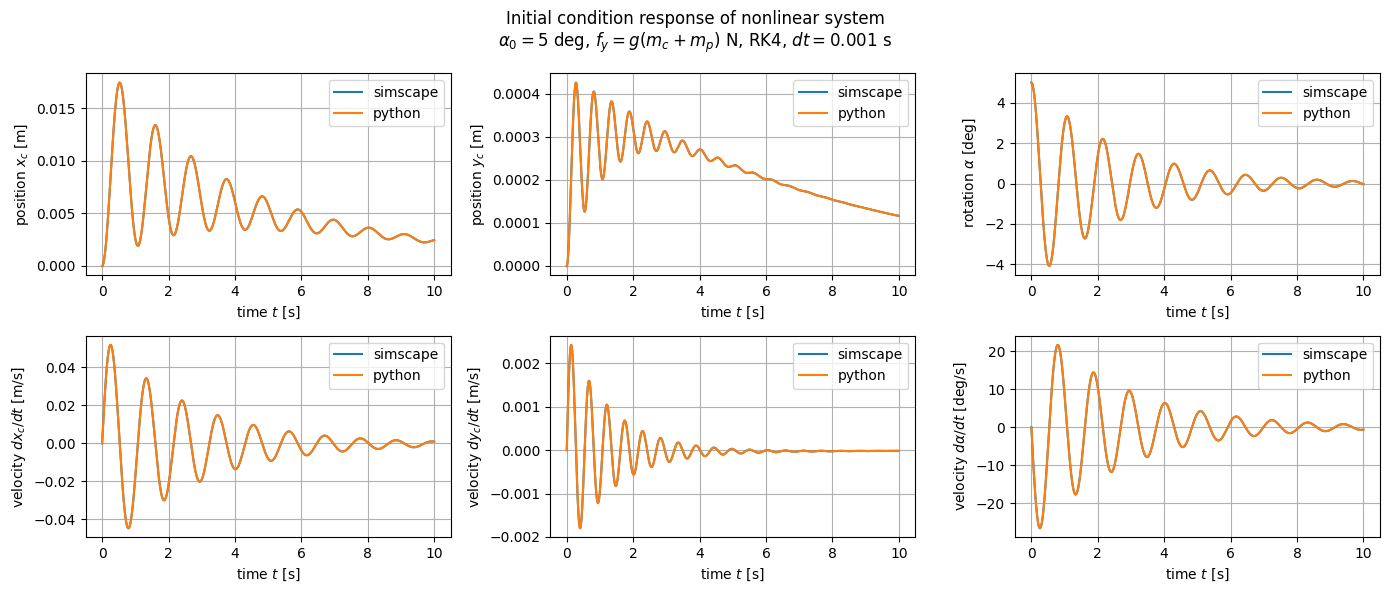

In [16]:
from simscape.simscape_initial_1 import data as simscape_initial_1

sim_initial_1 = rk4(
    f_func=non_lin_dynamics_c,
    u_func=lambda x, t: u0,
    x0=np.array([0, 0, math.radians(5), 0, 0, math.radians(0)], dtype=np.float64),
    n=6,
    m=2,
    dt=0.001,
    t0=0,
    t1=10,
)

plt.figure(figsize=(14, 6))
plot(*simscape_initial_1.T, label="simscape")
plot(sim_initial_1[0], *sim_initial_1[1].T, label="python")
plt.suptitle(
    r"Initial condition response of nonlinear system"
    "\n"
    r"$\alpha_0 = 5$ deg, $f_y = g (m_c + m_p)$ N, RK4, $dt = 0.001$ s"
)
plt.tight_layout()
plt.show()

del simscape_initial_1, sim_initial_1

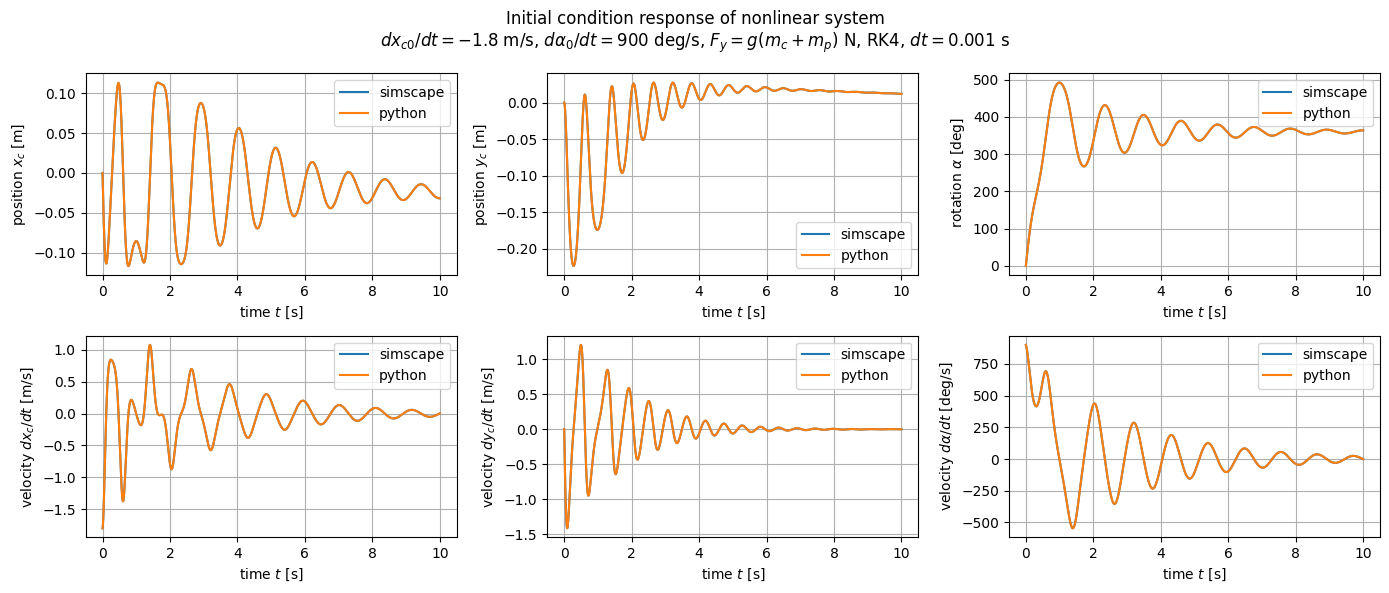

In [17]:
from simscape.simscape_initial_2 import data as simscape_initial_2

sim_initial_2 = rk4(
    f_func=non_lin_dynamics_c,
    u_func=lambda x, t: u0,
    x0=np.array([0, 0, math.radians(0), -1.8, 0, math.radians(900)], dtype=np.float64),
    n=6,
    m=2,
    dt=0.001,
    t0=0,
    t1=10,
)

plt.figure(figsize=(14, 6))
plot(*simscape_initial_2.T, label="simscape")
plot(sim_initial_2[0], *sim_initial_2[1].T, label="python")
plt.suptitle(
    r"Initial condition response of nonlinear system"
    "\n"
    r"$dx_{c0}/dt = -1.8$ m/s, $d\alpha_0/dt = 900$ deg/s, "
    r"$F_y = g (m_c + m_p)$ N, RK4, $dt = 0.001$ s"
)
plt.tight_layout()
plt.show()

del simscape_initial_2, sim_initial_2

# 3) Linearization

Linearization of a nonlinear system using the first-order terms of the Taylor expansion:

$$
\dot{\mathbf{x}} \approx
\underbrace{\mathbf{f}(\mathbf{x}_\text{s}, \mathbf{u}_\text{s}) \vphantom{\dfrac{}{}}}_{0} +
\underbrace{\dfrac{
    \partial \mathbf{f}(\mathbf{x}_\text{s}, \mathbf{u}_\text{s})
}{
    \partial \mathbf{x}} \vphantom{\dfrac{}{}
}}_{\mathbf{A}}
\underbrace{(\mathbf{x} - \mathbf{x}_\text{s}) \vphantom{\dfrac{}{}}}_{\Delta\mathbf{x}} +
\underbrace{\dfrac{
    \partial \mathbf{f}(\mathbf{x}_\text{s}, \mathbf{u}_\text{s})
}{
    \partial \mathbf{u}} \vphantom{\dfrac{}{}
}}_{\mathbf{B}}
\underbrace{(\mathbf{u} - \mathbf{u}_\text{s}) \vphantom{\dfrac{}{}}}_{\Delta\mathbf{u}}
$$

Controllability matrix:

$$
\mathcal{C} =
\begin{bmatrix}
\mathbf{A}^0 \mathbf{B} & \mathbf{A}^1 \mathbf{B} & \cdots & \mathbf{A}^{n-1} \mathbf{B}
\end{bmatrix}
$$

Condition for controllable systems:

$$
\mathrm{rank}(\mathcal{C}) \stackrel{!}{=} n
$$

In [18]:
ss_x_vec = smp.Matrix(ssx)
print2("state variables", ss_x_vec.T)

A_sym = ss_eom_num.jacobian(ss_x_vec)
print2("A", A_sym)

ss_u_vec = smp.Matrix(ssu)
print2("control variables", ss_u_vec.T)

B_sym = ss_eom_num.jacobian(ss_u_vec)
print2("B", B_sym)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Lower Equilibrium

In [19]:
ss_sub_lower = {
    ssx[0]: 0,  # x_c
    ssx[1]: 0,  # y_c
    ssx[2]: 0,  # alpha
    ssx[3]: 0,  # dx_c
    ssx[4]: 0,  # dy_c
    ssx[5]: 0,  # dalpha
    ssu[0]: u0_num[0, 0],  # f_x
    ssu[1]: u0_num[1, 0],  # f_y
}

A_num_lower = A_sym.subs(ss_sub_lower)
print2("A", A_num_lower)

A_lower = sympy.matrices.dense.matrix2numpy(A_num_lower, dtype=np.float64)
print_array(A_lower)

B_num_lower = B_sym.subs(ss_sub_lower)
print2("B", B_num_lower)

B_lower = sympy.matrices.dense.matrix2numpy(B_num_lower, dtype=np.float64)
print_array(B_lower)

<IPython.core.display.Latex object>

[[  0.         0.         0.         1.         0.         0.      ]
 [  0.         0.         0.         0.         1.         0.      ]
 [  0.         0.         0.         0.         0.         1.      ]
 [  0.         0.         3.924     -0.2        0.         0.08    ]
 [  0.         0.         0.         0.        -0.142857   0.      ]
 [  0.         0.       -34.335      0.5        0.        -0.7     ]]


<IPython.core.display.Latex object>

[[ 0.        0.      ]
 [ 0.        0.      ]
 [ 0.        0.      ]
 [ 2.        0.      ]
 [ 0.        1.428571]
 [-5.        0.      ]]


### Poles

In [20]:
print("Re\t\tIm")
for p in np.linalg.eigvals(A_lower):
    print(f"{p.real:7.4f}\t\t{p.imag:7.4f} j")

Re		Im
 0.0000		 0.0000 j
-0.3786		 5.8467 j
-0.3786		-5.8467 j
-0.1429		 0.0000 j
 0.0000		 0.0000 j
-0.1429		 0.0000 j


### Controllability

In [21]:
_ = np.hstack([np.linalg.matrix_power(A_lower, i) @ B_lower for i in range(0, A_lower.shape[0])])
int(np.linalg.matrix_rank(_))

6

## Upper Equilibrium

In [22]:
ss_sub_upper = {
    ssx[0]: 0,  # x_c
    ssx[1]: 0,  # y_c
    ssx[2]: smp.pi,  # alpha
    ssx[3]: 0,  # dx_c
    ssx[4]: 0,  # dy_c
    ssx[5]: 0,  # dalpha
    ssu[0]: u0_num[0, 0],  # f_x
    ssu[1]: u0_num[1, 0],  # f_y
}

A_num_upper = A_sym.subs(ss_sub_upper)
print2("A", A_num_upper)

A_upper = sympy.matrices.dense.matrix2numpy(A_num_upper, dtype=np.float64)
print_array(A_upper)

B_num_upper = B_sym.subs(ss_sub_upper)
print2("B", B_num_upper)

B_upper = sympy.matrices.dense.matrix2numpy(B_num_upper, dtype=np.float64)
print_array(B_upper)

<IPython.core.display.Latex object>

[[ 0.        0.        0.        1.        0.        0.      ]
 [ 0.        0.        0.        0.        1.        0.      ]
 [ 0.        0.        0.        0.        0.        1.      ]
 [ 0.        0.        3.924    -0.2       0.       -0.08    ]
 [ 0.        0.        0.        0.       -0.142857  0.      ]
 [ 0.        0.       34.335    -0.5       0.       -0.7     ]]


<IPython.core.display.Latex object>

[[0.       0.      ]
 [0.       0.      ]
 [0.       0.      ]
 [2.       0.      ]
 [0.       1.428571]
 [5.       0.      ]]


### Poles

In [23]:
print("Re\t\tIm")
for p in np.linalg.eigvals(A_upper):
    print(f"{p.real:7.4f}\t\t{p.imag:7.4f} j")

Re		Im
 0.0000		 0.0000 j
-6.2511		 0.0000 j
 5.4939		 0.0000 j
-0.1428		 0.0000 j
 0.0000		 0.0000 j
-0.1429		 0.0000 j


### Controllability

In [24]:
_ = np.hstack([np.linalg.matrix_power(A_upper, i) @ B_upper for i in range(0, A_upper.shape[0])])
int(np.linalg.matrix_rank(_))

6

# Model Setup for Control Toolbox

In [25]:
input_names = ["fx", "fy"]
output_names = ["x", "y", "a", "dx", "dy", "da"]
state_names = ["x", "y", "a", "dx", "dy", "da"]
reference_names = ["rx", "ry", "ra", "rdx", "rdy", "rda"]
Ts = 0.01
Ts_internal = 0.001
x0 = np.array([0, 0, math.radians(180), 0, 0, math.radians(0)], dtype=np.float64)

## State-Space Continuous-Time Nonlinear Model

$$
\begin{aligned}
\dot{\mathbf{x}}(t) &= \mathbf{f}\left( \mathbf{x}(t), \mathbf{u}(t) \right) \\
\mathbf{y}(t) &= \mathbf{x}(t)
\end{aligned}
$$

In [26]:
SSCTNL_model = control.NonlinearIOSystem(
    updfcn=lambda t, x, u, params: _non_lin_dynamics_c(*x, *u)[:, 0],
    outfcn=None,
    inputs=input_names,
    outputs=output_names,
    states=state_names,
    dt=0,  # continuous time
    name="system",
    params=None,
)
print(SSCTNL_model)

<NonlinearIOSystem>: system
Inputs (2): ['fx', 'fy']
Outputs (6): ['x', 'y', 'a', 'dx', 'dy', 'da']
States (6): ['x', 'y', 'a', 'dx', 'dy', 'da']

Update: <function <lambda> at 0x000001D90D0ECAE0>
Output: None


## State-Space Continuous-Time Linear Model

$$
\begin{aligned}
\mathbf{x}(t) &=
\mathbf{A} \left( \mathbf{x}(t) - \mathbf{x}_s \right) +
\mathbf{B} \left( \mathbf{u}(t) - \mathbf{u}_s \right) \\
\mathbf{y}(t) &= \mathbf{x}(t)
\end{aligned}
$$

In [27]:
SSCTL_model = SSCTNL_model.linearize(
    x0=x0,
    u0=u0,
    t=0,
    params=None,
    eps=1e-6,
    copy_names=True,
    name="system",
)
print(SSCTL_model)

<StateSpace>: system
Inputs (2): ['fx', 'fy']
Outputs (6): ['x', 'y', 'a', 'dx', 'dy', 'da']
States (6): ['x', 'y', 'a', 'dx', 'dy', 'da']

A = [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
       0.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
       1.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
       0.00000000e+00  1.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00  3.92400000e+00 -2.00000000e-01
       6.99798174e-18 -8.00000000e-02]
     [ 0.00000000e+00  0.00000000e+00  3.92397226e-06  0.00000000e+00
      -1.42857143e-01  1.13686838e-07]
     [ 0.00000000e+00  0.00000000e+00  3.43350000e+01 -5.00000000e-01
       6.12323404e-17 -7.00000000e-01]]

B = [[ 0.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00]
     [ 2.00000000e+00 -6.99798172e-17]
     [ 0.00000000e+00  1.42857143e+00]
     [ 5.

In [28]:
print("Re\t\tIm")
for p in SSCTL_model.poles():
    print(f"{p.real:7.4f}\t\t{p.imag:7.4f} j")

Re		Im
 0.0000		 0.0000 j
 0.0000		 0.0000 j
-6.2511		 0.0000 j
 5.4939		 0.0000 j
-0.1428		 0.0000 j
-0.1429		 0.0000 j


In [29]:
# Difference between sympy's and control's A matrices
float(np.linalg.norm(SSCTL_model.A - A_upper))

3.925621769629603e-06

## State-Space Discrete-Time Linear Model

$$
\begin{aligned}
\mathbf{x}_{k + 1} &=
\mathbf{A}_\text{d} \left( \mathbf{x}_k - \mathbf{x}_s \right) +
\mathbf{B}_\text{d} \left( \mathbf{u}_k - \mathbf{u}_s \right) \\
\mathbf{y}_k &= \mathbf{x}_k
\end{aligned}
$$

Zero-Order Hold:

$$
\begin{aligned}
\mathbf{A}_\text{d} &= e^{\mathbf{A}T} \\
\mathbf{B}_\text{d} &= \int_{0}^{T} e^{\mathbf{A}t} \, \text{d}t \, \mathbf{B}
\end{aligned}
$$

Forward (Explicit) Euler:

$$
\begin{aligned}
\mathbf{A}_\text{d} &= \mathbf{I} + T\mathbf{A} \\
\mathbf{B}_\text{d} &= T\mathbf{B}
\end{aligned}
$$

In [30]:
SSDTL_model = SSCTL_model.sample(
    Ts=Ts,
    method="zoh",
    copy_names=True,
    name="system",
)
print(SSDTL_model)

<StateSpace>: system
Inputs (2): ['fx', 'fy']
Outputs (6): ['x', 'y', 'a', 'dx', 'dy', 'da']
States (6): ['x', 'y', 'a', 'dx', 'dy', 'da']

A = [[ 1.00000000e+00  0.00000000e+00  1.95668518e-04  9.99001250e-03
       3.48785038e-22 -3.33652168e-06]
     [ 0.00000000e+00  1.00000000e+00  1.96810484e-10 -1.02667505e-14
       9.99286054e-03  6.32275520e-12]
     [ 0.00000000e+00  0.00000000e+00  1.00171292e+00 -2.49322780e-05
       3.05332346e-21  9.97079084e-03]
     [ 0.00000000e+00  0.00000000e+00  3.90862496e-02  9.98003666e-01
       6.96557955e-20 -6.01196917e-04]
     [ 0.00000000e+00  0.00000000e+00  3.94287591e-08 -3.15932425e-12
       9.98572448e-01  1.32844209e-09]
     [ 0.00000000e+00  0.00000000e+00  3.42249269e-01 -4.98040897e-03
       6.09924194e-19  9.94735356e-01]]

B = [[ 9.98750296e-05 -3.48785037e-21]
     [ 1.02667505e-13  7.13945700e-05]
     [ 2.49322780e-04 -3.05332344e-20]
     [ 1.99633424e-02 -6.96557954e-19]
     [ 3.15932425e-11  1.42755151e-02]
     [ 4.

In [31]:
print("Re\t\tIm")
for p in SSDTL_model.poles():
    print(f"{p.real:7.4f}\t\t{p.imag:7.4f} j")

Re		Im
 1.0000		 0.0000 j
 1.0000		 0.0000 j
 0.9394		 0.0000 j
 1.0565		 0.0000 j
 0.9986		 0.0000 j
 0.9986		 0.0000 j


## State-Space Discrete-Time Nonlinear Model

$$
\begin{aligned}
\mathbf{x}_{k + 1} &=
\mathbf{x}_k +
\int_{k T}^{(k + 1) T} \mathbf{f}\left( \mathbf{x}(t), \mathbf{u}_k \right) \text{d}t \\
\mathbf{y}_k &= \mathbf{x}_k
\end{aligned}
$$

In [32]:
SSDTNL_model = control.NonlinearIOSystem(
    updfcn=discretization_by_rk4_integration,
    outfcn=None,
    inputs=input_names,
    outputs=output_names,
    states=state_names,
    dt=Ts,  # discrete time
    name="system",
    params={
        "f_func": lambda x, u, t: _non_lin_dynamics_c(*x, *u)[:, 0],
        "dt": Ts,
        "dt_internal": Ts_internal,
    },
)
print(SSDTNL_model)

<NonlinearIOSystem>: system
Inputs (2): ['fx', 'fy']
Outputs (6): ['x', 'y', 'a', 'dx', 'dy', 'da']
States (6): ['x', 'y', 'a', 'dx', 'dy', 'da']

Update: <function discretization_by_rk4_integration at 0x000001D97FB40F40>
Output: None


## Disturbance Model

In [33]:
disturbance_model = control.StateSpace(
    np.zeros((0, 0), dtype=np.float64),
    np.zeros((0, 2), dtype=np.float64),
    np.zeros((2, 0), dtype=np.float64),
    np.eye(2),
    None,
    inputs=["in_" + i for i in input_names],
    outputs=["out_" + i for i in input_names],
    states=[],
    name="disturb",
)
print(disturbance_model)

<StateSpace>: disturb
Inputs (2): ['in_fx', 'in_fy']
Outputs (2): ['out_fx', 'out_fy']
States (0): []

A = []

B = []

C = []

D = [[1. 0.]
     [0. 1.]]



## Model Comparison

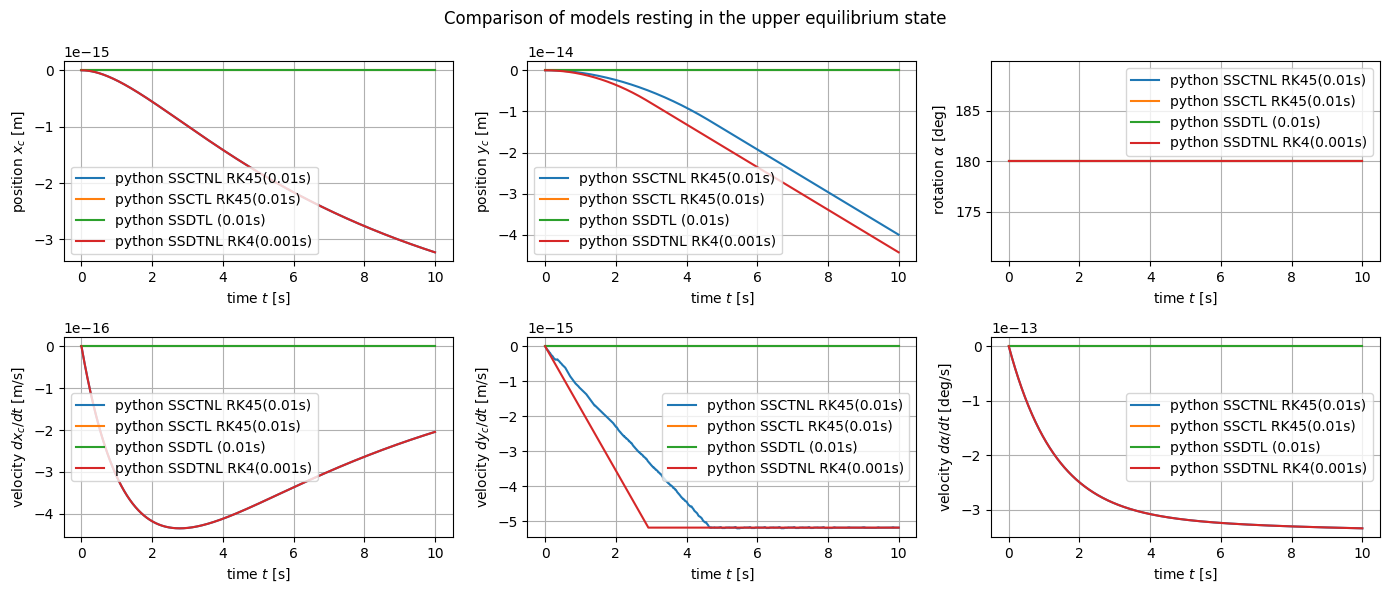

In [34]:
time_vector = np.arange(0, 10 + 1e-6, Ts)
_US = np.zeros((time_vector.shape[0], 2))
_US[:] = u0

SSCTNL_initial_1 = control.input_output_response(
    SSCTNL_model,
    T=time_vector,
    U=_US.T,  # type: ignore
    X0=x0,  # type: ignore
    solve_ivp_method="RK45",
    solve_ivp_kwargs={"max_step": Ts},
)
SSCTL_initial_1 = control.input_output_response(
    SSCTL_model,
    T=time_vector,
    U=0,  # !!!
    X0=0,  # !!!
    solve_ivp_method="RK45",
    solve_ivp_kwargs={"max_step": Ts},
)
SSCTL_initial_1.y = SSCTL_initial_1.y + x0[:, np.newaxis]  # !!!
SSDTL_initial_1 = control.input_output_response(
    SSDTL_model,
    T=time_vector,
    U=0,  # !!!
    X0=0,  # !!!
)
SSDTL_initial_1.y = SSDTL_initial_1.y + x0[:, np.newaxis]  # !!!
SSDTNL_initial_1 = control.input_output_response(
    SSDTNL_model,
    T=time_vector,
    U=_US.T,  # type: ignore
    X0=x0,  # type: ignore
)

plt.figure(figsize=(14, 6))
plot(SSCTNL_initial_1.t, *SSCTNL_initial_1.y, label="python SSCTNL RK45(0.01s)")
plot(SSCTL_initial_1.t, *SSCTL_initial_1.y, label="python SSCTL RK45(0.01s)")
plot(SSDTL_initial_1.t, *SSDTL_initial_1.y, label="python SSDTL (0.01s)")
plot(SSDTNL_initial_1.t, *SSDTNL_initial_1.y, label="python SSDTNL RK4(0.001s)")
plt.suptitle("Comparison of models resting in the upper equilibrium state")
plt.tight_layout()
plt.show()

del time_vector, _US, SSCTNL_initial_1, SSCTL_initial_1, SSDTL_initial_1, SSDTNL_initial_1

# 4) Discrete Infinite-Horizon LQR Controller

## DARE and Gain

https://jurajlieskovsky.github.io/OPCS2025/LQR-DT.html

$$
\mathbf{Q} \succeq 0, \quad \mathbf{R} \succ 0
$$

$$
\mathbf{S} = \mathbf{Q} + \mathbf{A}^T \mathbf{S} \mathbf{A} - \mathbf{A}^T \mathbf{S} \mathbf{B} \left( \mathbf{B}^T \mathbf{S} \mathbf{B} + \mathbf{R} \right)^{-1} \mathbf{B}^T \mathbf{S} \mathbf{A}
$$

$$
\mathbf{K} = \left( \mathbf{B}^T \mathbf{S} \mathbf{B} + \mathbf{R} \right)^{-1} \mathbf{B}^T \mathbf{S} \mathbf{A}
$$

In [35]:
Q_lqr = np.diag([10, 10, 100, 1, 1, 1])
R_lqr = np.diag([0.1, 0.1])

# Solve discrete-time Riccati equation (DARE)
S_lqr = solve_discrete_are(SSDTL_model.A, SSDTL_model.B, Q_lqr, R_lqr)
# Compute state-feedback gain
assert isinstance(SSDTL_model.B, np.ndarray)  # better type hinting
K_lqr = np.linalg.inv(SSDTL_model.B.T @ S_lqr @ SSDTL_model.B + R_lqr) @ (SSDTL_model.B.T @ S_lqr @ SSDTL_model.A)

print_array(K_lqr)

[[-8.689351  0.       54.726693 -9.709088  0.        9.002431]
 [ 0.        9.66298   0.000001  0.        4.683762 -0.      ]]


## Full State Feedback Controller

In [36]:
lqr_controller = control.NonlinearIOSystem(
    updfcn=lambda _, __, x, ___: np.zeros((0,)),  # no dynamics
    outfcn=lambda _, __, x, ___: (u0.flatten() + (-K_lqr @ (x[:6] - x[6:])).flatten()),  # (x - x0) - (r - x0) = x - r
    inputs=state_names + reference_names,
    outputs=input_names,
    states=[],
    dt=None,  # static
    name="lqr",
)
print(lqr_controller)

<NonlinearIOSystem>: lqr
Inputs (12): ['x', 'y', 'a', 'dx', 'dy', 'da', 'rx', 'ry', 'ra', 'rdx', 'rdy', 'rda']
Outputs (2): ['fx', 'fy']
States (0): []

Update: <function <lambda> at 0x000001D90B5F65C0>
Output: <function <lambda> at 0x000001D90B5F6AC0>


## Closed-Loop System

In [37]:
closed_loop = control.InterconnectedSystem(
    (SSDTNL_model, lqr_controller, disturbance_model),
    connections=[
        ["system.fx", "lqr.fx", "disturb.out_fx"],  # system.fx <- lqr.fx + disturb.fx
        ["system.fy", "lqr.fy", "disturb.out_fy"],  # system.fy <- lqr.fy + disturb.fy
        ["lqr.x", "system.x"],  # lqr.x <- system.x
        ["lqr.y", "system.y"],  # lqr.y <- system.y
        ["lqr.a", "system.a"],  # lqr.a <- system.a
        ["lqr.dx", "system.dx"],  # lqr.dx <- system.dx
        ["lqr.dy", "system.dy"],  # lqr.dy <- system.dy
        ["lqr.da", "system.da"],  # lqr.da <- system.da
    ],
    inplist=[
        "lqr.rx",
        "lqr.ry",
        "lqr.ra",
        "lqr.rdx",
        "lqr.rdy",
        "lqr.rda",
        "disturb.in_fx",
        "disturb.in_fy",
    ],
    outlist=[
        "system.x",
        "system.y",
        "system.a",
        "system.dx",
        "system.dy",
        "system.da",
        "lqr.fx",
        "lqr.fy",
    ],
    name="closed_loop",
)
print(closed_loop)
with warnings.catch_warnings(action="ignore"):
    print(closed_loop.connection_table(show_names=True))

<InterconnectedSystem>: closed_loop
Inputs (8): ['u[0]', 'u[1]', 'u[2]', 'u[3]', 'u[4]', 'u[5]', 'u[6]', 'u[7]']
Outputs (8): ['y[0]', 'y[1]', 'y[2]', 'y[3]', 'y[4]', 'y[5]', 'y[6]', 'y[7]']
States (6): ['system_x', 'system_y', 'system_a', 'system_dx', 'system_dy', 'system_da']

Update: <function InterconnectedSystem.__init__.<locals>.updfcn at 0x000001D90B99BF60>
Output: <function InterconnectedSystem.__init__.<locals>.outfcn at 0x000001D90B99AAC0>
signal    | source                        | destination
--------------------------------------------------------------------------
rx        |                               | lqr                           
a         | system                        | lqr                           
y         | system                        | lqr                           
x         | system                        | lqr                           
rda       |                               | lqr                           
ry        |                             

## Simulations

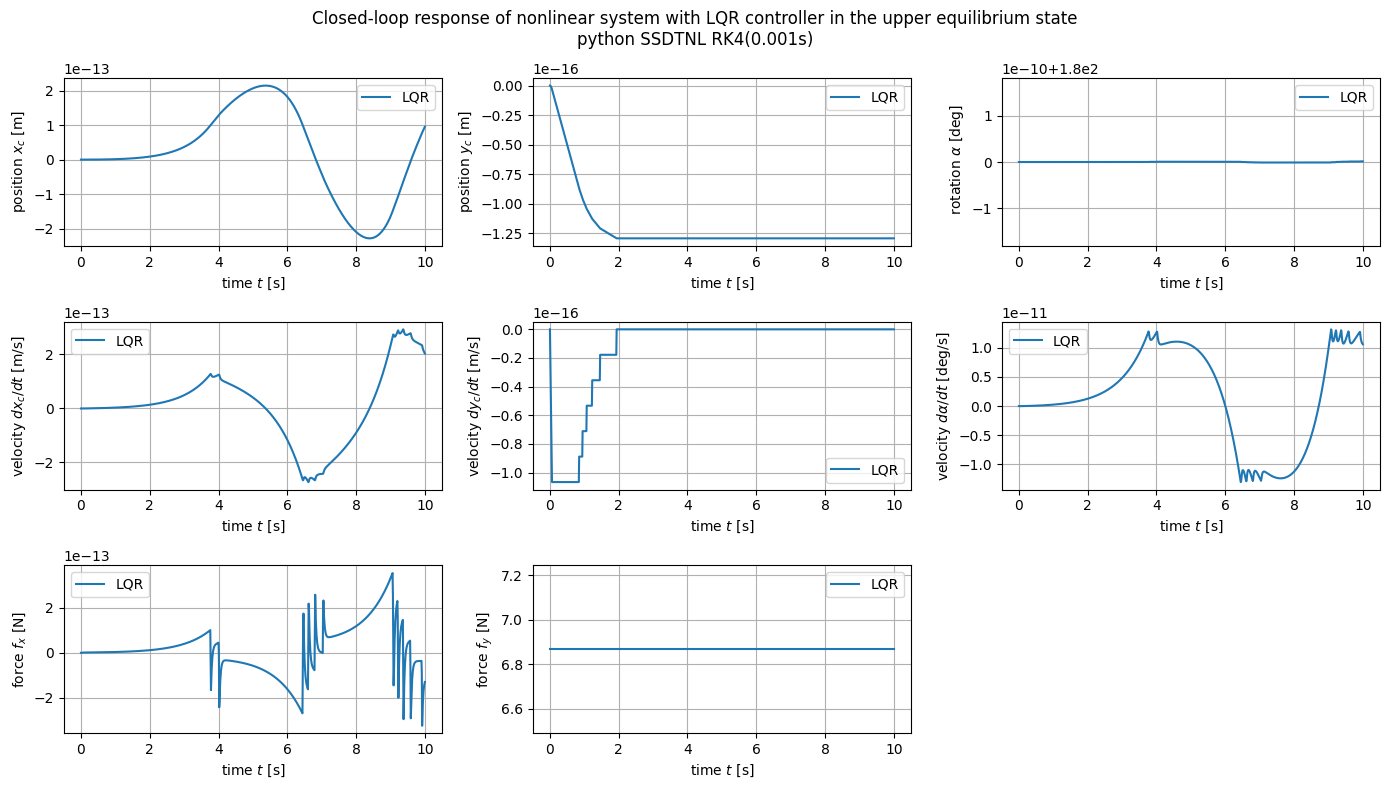

In [38]:
time_vector = np.arange(0, 10 + 1e-6, Ts)
reference_vector = np.zeros((6, time_vector.shape[0]), dtype=np.float64)
reference_vector[2, :] = np.pi
disturbance_vector = np.zeros((2, time_vector.shape[0]), dtype=np.float64)

sim_lqr_1 = control.input_output_response(
    sys=closed_loop,
    T=time_vector,
    U=np.vstack([reference_vector, disturbance_vector]),  # type: ignore
    X0=x0,  # type: ignore
)

plt.figure(figsize=(14, 8))
plot2(sim_lqr_1.t, *sim_lqr_1.y, label="LQR")
plt.suptitle(
    "Closed-loop response of nonlinear system with LQR controller in the upper equilibrium state"
    "\n"
    "python SSDTNL RK4(0.001s)"
)
plt.tight_layout()
plt.show()

del time_vector, reference_vector, disturbance_vector

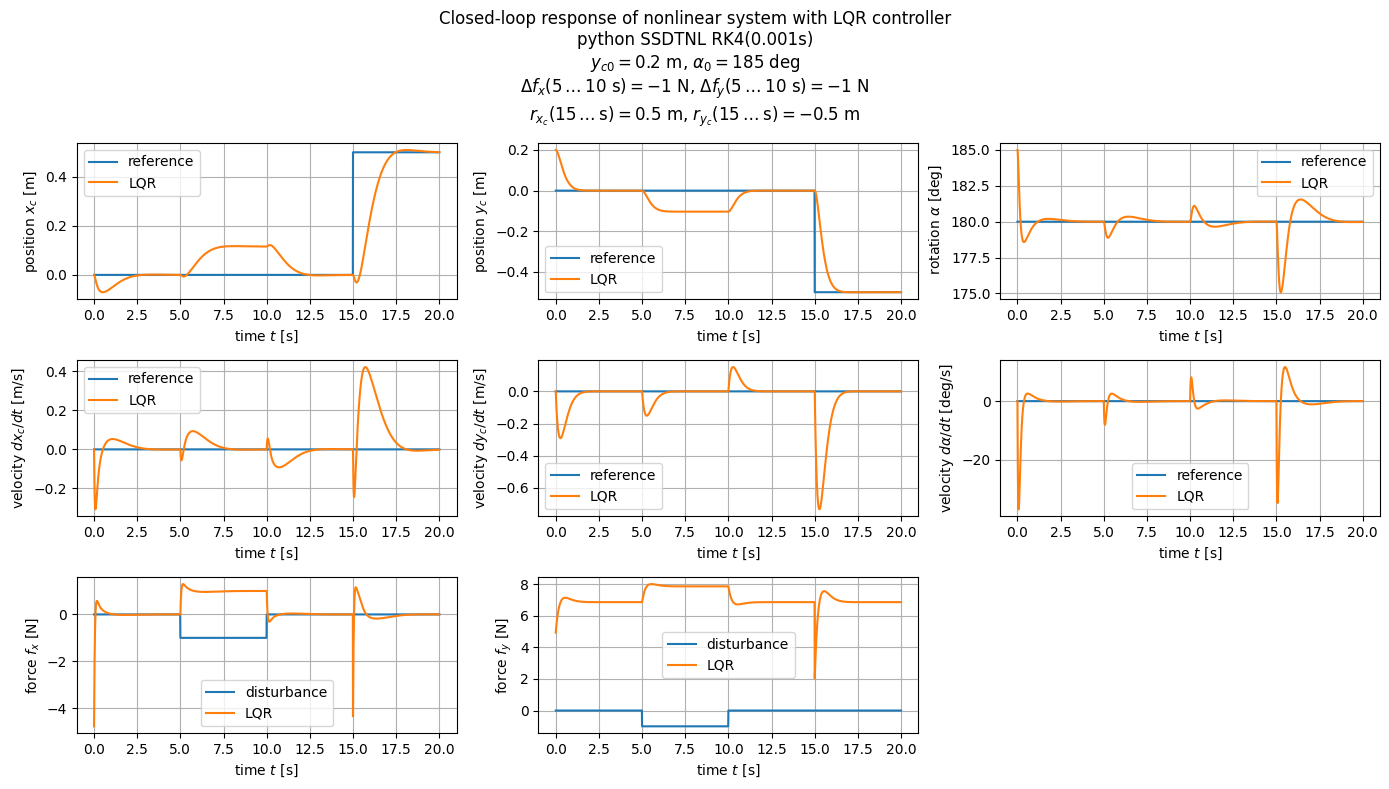

In [39]:
time_vector = np.arange(0, 20 + 1e-6, Ts)
reference_vector = np.zeros((6, time_vector.shape[0]), dtype=np.float64)
reference_vector[2, :] = np.pi  # ra
reference_vector[0, int(15 / Ts) :] = 0.5  # rxc = 0.5m from 15s
reference_vector[1, int(15 / Ts) :] = -0.5  # ryc = -0.5m from 15s
disturbance_vector = np.zeros((2, time_vector.shape[0]), dtype=np.float64)
disturbance_vector[0, int(5 / Ts) : int(10 / Ts)] = -1  # dfx = -1N from 5s to 10s
disturbance_vector[1, int(5 / Ts) : int(10 / Ts)] = -1  # dfy = -1N from 5s to 10s

sim_lqr_2 = control.input_output_response(
    sys=closed_loop,
    T=time_vector,
    U=np.vstack([reference_vector, disturbance_vector]),  # type: ignore
    X0=x0 + np.array([0, 0.2, math.radians(5), 0, 0, math.radians(0)]),  # type: ignore
)

plt.figure(figsize=(14, 8))
plot2(sim_lqr_2.t, *[None] * 6, f_x=disturbance_vector[0], f_y=disturbance_vector[1], label="disturbance")
plot(sim_lqr_2.t, *reference_vector, label="reference", rows=3)
plot2(sim_lqr_2.t, *sim_lqr_2.y, label="LQR")
plt.suptitle(
    (
        "Closed-loop response of nonlinear system with LQR controller"
        "\n"
        "python SSDTNL RK4(0.001s)"
        "\n"
        r"$y_{c0} = 0.2$ m, $\alpha_0 = 185$ deg"
        "\n"
        r"$\Delta f_x(5 \dots 10\ \text{s}) = -1$ N, $\Delta f_y(5 \dots 10\ \text{s}) = -1$ N"
        "\n"
        r"$r_{x_c}(15 \dots \text{s}) = 0.5$ m, $r_{y_c}(15 \dots \text{s}) = -0.5$ m"
    )
)
plt.tight_layout()
plt.show()

sim_lqr_2_r = reference_vector.copy()
sim_lqr_2_d = disturbance_vector.copy()
del time_vector, reference_vector, disturbance_vector

# Discrete Infinite-Horizon Augmented LQR Controller

[Moodle ŘSP: Stavový regulátor pro řízení, pozorovatelnost, pozorovatel stavu](https://moodle-vyuka.cvut.cz/pluginfile.php/802902/mod_resource/content/1/Prednaska_8.pdf)

$$
\underbrace{
    \begin{bmatrix}
        \dot{\mathbf{x}}(t) \\ \dot{\mathbf{I}}(t)
    \end{bmatrix}
}_{\dot{\mathbf{x}}_\text{aug}}
=
\underbrace{
    \begin{bmatrix}
        \mathbf{A} & \mathbf{0} \\
        \mathbf{C} & \mathbf{0}
    \end{bmatrix}
}_{\mathbf{A}_\text{aug}}
\underbrace{
    \begin{bmatrix}
        \mathbf{x}(t) \\ \mathbf{I}(t)
    \end{bmatrix}
}_{\mathbf{x}_\text{aug}}
+
\underbrace{
    \begin{bmatrix}
        \mathbf{B} \\ \mathbf{0}
    \end{bmatrix}
}_{\mathbf{B}_{\mathbf{u},\text{aug}}}
\mathbf{u}(t)
-
\underbrace{
    \begin{bmatrix}
        \mathbf{0} \\ \mathbf{C}
    \end{bmatrix}
}_{\mathbf{B}_{\mathbf{r},\text{aug}}}
\mathbf{r}(t)
$$

$$
\mathbf{A}_\text{aug} = \begin{bmatrix}
    \mathbf{A} & \mathbf{0}^{(6 \times 2)} \\
    \mathbf{1}^{(2 \times 6)} & \mathbf{0}^{(2 \times 2)}
\end{bmatrix} \quad
\mathbf{B}_{\mathbf{u}, \text{aug}} = \begin{bmatrix}
    \mathbf{B} \\
    \mathbf{0}^{(2 \times 2)}
\end{bmatrix} \quad
$$

In [40]:
_ = np.vstack([SSCTL_model.A, np.eye(2, 6)])
A_upper_aug = np.hstack([_, np.zeros((8, 2))])
print("A_upper_aug")
print_array(A_upper_aug)

B_upper_aug = np.vstack([SSCTL_model.B, np.zeros((2, 2))])
print("B_upper_aug")
print_array(B_upper_aug)

_ = np.hstack([np.linalg.matrix_power(A_upper_aug, i) @ B_upper_aug for i in range(0, A_upper_aug.shape[0])])
print("controllability rank =", int(np.linalg.matrix_rank(_)))

A_upper_aug_dt = np.eye(A_upper_aug.shape[0]) + A_upper_aug * Ts
print("A_upper_aug_dt")
print_array(A_upper_aug_dt)

B_upper_aug_dt = B_upper_aug * Ts
print("B_upper_aug_dt")
print_array(B_upper_aug_dt)

A_upper_aug
[[ 0.        0.        0.        1.        0.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        1.        0.        0.        0.      ]
 [ 0.        0.        0.        0.        0.        1.        0.        0.      ]
 [ 0.        0.        3.924    -0.2       0.       -0.08      0.        0.      ]
 [ 0.        0.        0.000004  0.       -0.142857  0.        0.        0.      ]
 [ 0.        0.       34.335    -0.5       0.       -0.7       0.        0.      ]
 [ 1.        0.        0.        0.        0.        0.        0.        0.      ]
 [ 0.        1.        0.        0.        0.        0.        0.        0.      ]]
B_upper_aug
[[ 0.        0.      ]
 [ 0.        0.      ]
 [ 0.        0.      ]
 [ 2.       -0.      ]
 [ 0.        1.428571]
 [ 5.       -0.      ]
 [ 0.        0.      ]
 [ 0.        0.      ]]
controllability rank = 8
A_upper_aug_dt
[[ 1.        0.        0.        0.01      0.        0.        0.        0.      ]
 [ 

## DARE and Gain

In [41]:
Q_lqr_aug = np.diag([10, 10, 100, 1, 1, 1, 10, 10])
R_lqr_aug = np.diag([0.1, 0.1])

# Solve discrete-time Riccati equation (DARE)
S_lqr_aug = solve_discrete_are(A_upper_aug_dt, B_upper_aug_dt, Q_lqr_aug, R_lqr_aug)
# Compute state-feedback gain
assert isinstance(B_upper_aug_dt, np.ndarray)  # better type hinting
_ = np.linalg.inv(B_upper_aug_dt.T @ S_lqr_aug @ B_upper_aug_dt + R_lqr_aug)
K_lqr_aug = _ @ (B_upper_aug_dt.T @ S_lqr_aug @ A_upper_aug_dt)

print_array(K_lqr_aug)

[[-17.897346   0.        64.780632 -14.16461    0.        11.126708  -8.663736   0.      ]
 [  0.000001  14.089836   0.000001   0.000001   5.336021  -0.         0.         9.621144]]


## Full State Feedback Controller

- inputs: $\mathbf{x}$, $\mathbf{r}$
- states: $\mathbf{I}$
- outputs: $\mathbf{u}$

$$
\begin{aligned}
\begin{bmatrix} \dot{I}_{x_c} \\ \dot{I}_{y_c} \end{bmatrix} &=
\underbrace{\begin{bmatrix} \mathbf{0}^{(2 \times 2)} \end{bmatrix}}_{\mathbf{A}_\text{LQR,aug}}
\begin{bmatrix} I_{x_c} \\ I_{y_c} \end{bmatrix} +
\underbrace{\begin{bmatrix} -\mathbf{1}^{(2 \times 6)} & \mathbf{1}^{(2 \times 6)} \end{bmatrix}}_{\mathbf{B}_\text{LQR,aug}}
\begin{bmatrix} \mathbf{x} \\ \mathbf{r} \end{bmatrix} \\
%
\begin{bmatrix} f_x \\ f_y \end{bmatrix} &=
\underbrace{\begin{bmatrix} -\mathbf{K}_{[:,\, 6:]} \end{bmatrix}}_{\mathbf{C}_\text{LQR,aug}}
\begin{bmatrix} I_{x_c} \\ I_{y_c} \end{bmatrix} +
\underbrace{\begin{bmatrix} -\mathbf{K}_{[:,\, :6]} & \mathbf{K}_{[:,\, 6:]} \end{bmatrix}}_{\mathbf{D}_\text{LQR,aug}}
\begin{bmatrix} \mathbf{x} \\ \mathbf{r} \end{bmatrix}
\end{aligned}
$$

In [42]:
A_lqr_aug = np.zeros((2, 2))
B_lqr_aug = np.hstack([np.eye(2, 6), -np.eye(2, 6)])
C_lqr_aug = -K_lqr_aug[:, 6:]
D_lqr_aug = np.hstack([-K_lqr_aug[:, :6], K_lqr_aug[:, :6]])
# D_lqr_aug[:, 6:8] = 0

_lqr_aug_controller = control.StateSpace(
    A_lqr_aug,
    B_lqr_aug,
    C_lqr_aug,
    D_lqr_aug,
    inputs=["in_" + i for i in state_names] + ["in_" + i for i in reference_names],
    outputs=["out_" + i for i in input_names],
    states=["i_xc", "i_yc"],
    name="lqr_aug",
)
print(_lqr_aug_controller)

<StateSpace>: lqr_aug
Inputs (12): ['in_x', 'in_y', 'in_a', 'in_dx', 'in_dy', 'in_da', 'in_rx', 'in_ry', 'in_ra', 'in_rdx', 'in_rdy', 'in_rda']
Outputs (2): ['out_fx', 'out_fy']
States (2): ['i_xc', 'i_yc']

A = [[0. 0.]
     [0. 0.]]

B = [[ 1.  0.  0.  0.  0.  0. -1. -0. -0. -0. -0. -0.]
     [ 0.  1.  0.  0.  0.  0. -0. -1. -0. -0. -0. -0.]]

C = [[ 8.66373553e+00 -2.79696607e-07]
     [-3.31195850e-07 -9.62114354e+00]]

D = [[ 1.78973464e+01 -3.97676125e-07 -6.47806318e+01  1.41646096e+01
      -1.28648810e-07 -1.11267077e+01 -1.78973464e+01  3.97676125e-07
       6.47806318e+01 -1.41646096e+01  1.28648810e-07  1.11267077e+01]
     [-6.97424899e-07 -1.40898358e+01 -6.31796653e-07 -5.51667087e-07
      -5.33602055e+00  1.70838263e-07  6.97424899e-07  1.40898358e+01
       6.31796653e-07  5.51667087e-07  5.33602055e+00 -1.70838263e-07]]



In [43]:
lqr_aug_controller = _lqr_aug_controller.sample(
    Ts=Ts,
    method="zoh",
    copy_names=True,
    name="lqr_aug",
)
print(lqr_aug_controller)

<StateSpace>: lqr_aug
Inputs (12): ['in_x', 'in_y', 'in_a', 'in_dx', 'in_dy', 'in_da', 'in_rx', 'in_ry', 'in_ra', 'in_rdx', 'in_rdy', 'in_rda']
Outputs (2): ['out_fx', 'out_fy']
States (2): ['i_xc', 'i_yc']

A = [[1. 0.]
     [0. 1.]]

B = [[ 0.01  0.    0.    0.    0.    0.   -0.01  0.    0.    0.    0.    0.  ]
     [ 0.    0.01  0.    0.    0.    0.    0.   -0.01  0.    0.    0.    0.  ]]

C = [[ 8.66373553e+00 -2.79696607e-07]
     [-3.31195850e-07 -9.62114354e+00]]

D = [[ 1.78973464e+01 -3.97676125e-07 -6.47806318e+01  1.41646096e+01
      -1.28648810e-07 -1.11267077e+01 -1.78973464e+01  3.97676125e-07
       6.47806318e+01 -1.41646096e+01  1.28648810e-07  1.11267077e+01]
     [-6.97424899e-07 -1.40898358e+01 -6.31796653e-07 -5.51667087e-07
      -5.33602055e+00  1.70838263e-07  6.97424899e-07  1.40898358e+01
       6.31796653e-07  5.51667087e-07  5.33602055e+00 -1.70838263e-07]]

dt = 0.01



In [44]:
input_offset_model = control.NonlinearIOSystem(
    updfcn=lambda *args: np.zeros((0,)),  # no dynamics
    outfcn=lambda *args: u0,  # no dynamics
    inputs=[],
    outputs=["out_dfx", "out_dfy"],
    states=[],
    dt=None,  # static
    name="input_offset",
)
print(input_offset_model)

<NonlinearIOSystem>: input_offset
Inputs (0): []
Outputs (2): ['out_dfx', 'out_dfy']
States (0): []

Update: <function <lambda> at 0x000001D90B8D5760>
Output: <function <lambda> at 0x000001D90B8D4540>


## Closed-Loop System

In [45]:
closed_loop_aug = control.InterconnectedSystem(
    (SSDTNL_model, lqr_aug_controller, disturbance_model, input_offset_model),
    connections=[
        # system.fx <- lqr_aug.out_fx + disturb.out_fx + input_offset.out_dfx
        [
            "system.fx",
            "lqr_aug.out_fx",
            "disturb.out_fx",
            "input_offset.out_dfx",
        ],
        # system.fy <- lqr_aug.out_fy + disturb.out_fy + input_offset.out_dfy
        [
            "system.fy",
            "lqr_aug.out_fy",
            "disturb.out_fy",
            "input_offset.out_dfy",
        ],
        ["lqr_aug.in_x", "system.x"],  # lqr_aug.in_x <- system.x
        ["lqr_aug.in_y", "system.y"],  # lqr_aug.in_y <- system.y
        ["lqr_aug.in_a", "system.a"],  # lqr_aug.in_a <- system.a
        ["lqr_aug.in_dx", "system.dx"],  # lqr_aug.in_dx <- system.dx
        ["lqr_aug.in_dy", "system.dy"],  # lqr_aug.in_dy <- system.dy
        ["lqr_aug.in_da", "system.da"],  # lqr_aug.in_da <- system.da
    ],
    inplist=[
        "lqr_aug.in_rx",
        "lqr_aug.in_ry",
        "lqr_aug.in_ra",
        "lqr_aug.in_rdx",
        "lqr_aug.in_rdy",
        "lqr_aug.in_rda",
        "disturb.in_fx",
        "disturb.in_fy",
    ],
    outlist=[
        "system.x",
        "system.y",
        "system.a",
        "system.dx",
        "system.dy",
        "system.da",
        "lqr_aug.out_fx",
        "lqr_aug.out_fy",
    ],
    name="closed_loop_aug",
)
print(closed_loop_aug)
with warnings.catch_warnings(action="ignore"):
    print(closed_loop_aug.connection_table(show_names=True))

<InterconnectedSystem>: closed_loop_aug
Inputs (8): ['u[0]', 'u[1]', 'u[2]', 'u[3]', 'u[4]', 'u[5]', 'u[6]', 'u[7]']
Outputs (8): ['y[0]', 'y[1]', 'y[2]', 'y[3]', 'y[4]', 'y[5]', 'y[6]', 'y[7]']
States (8): ['system_x', 'system_y', 'system_a', 'system_dx', 'system_dy', 'system_da', 'lqr_aug_i_xc', 'lqr_aug_i_yc']

Update: <function InterconnectedSystem.__init__.<locals>.updfcn at 0x000001D90B4C5760>
Output: <function InterconnectedSystem.__init__.<locals>.outfcn at 0x000001D90B4C5A80>
signal    | source                        | destination
--------------------------------------------------------------------------
in_x      |                               | lqr_aug                       
in_rdx    |                               | lqr_aug                       
in_a      |                               | lqr_aug                       
a         | system                        |                               
x         | system                        |                               
in_y

## Simulations

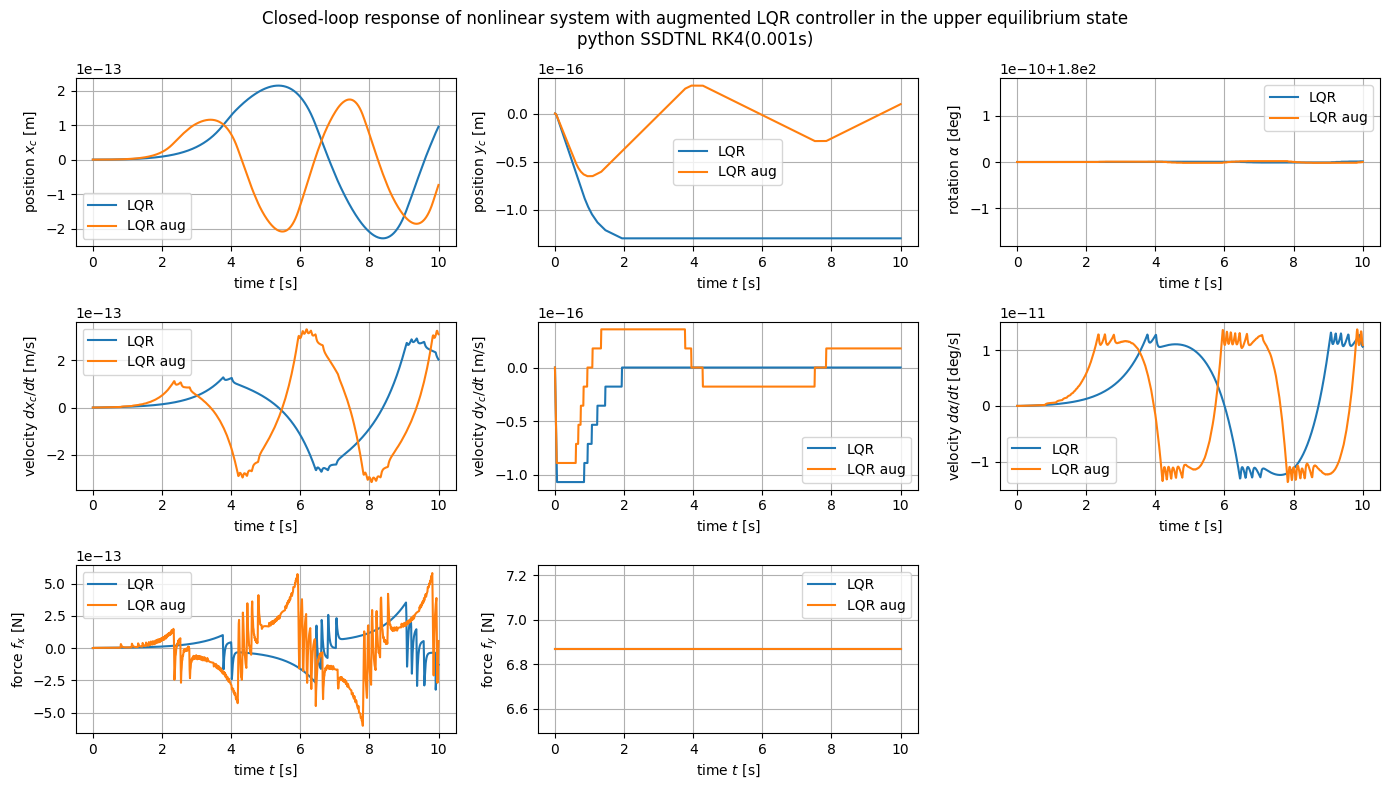

In [46]:
time_vector = np.arange(0, 10 + 1e-6, Ts)
reference_vector = np.zeros((6, time_vector.shape[0]), dtype=np.float64)
reference_vector[2, :] = np.pi
disturbance_vector = np.zeros((2, time_vector.shape[0]), dtype=np.float64)

_ = control.input_output_response(
    sys=closed_loop_aug,
    T=time_vector,
    U=np.vstack([reference_vector, disturbance_vector]),  # type: ignore
    X0=np.hstack([x0, np.zeros((2,))]),  # type: ignore
)
_.y[6:8] = _.y[6:8] + u0[:, np.newaxis]  # !!!

plt.figure(figsize=(14, 8))
plot2(sim_lqr_1.t, *sim_lqr_1.y, label="LQR")
plot2(_.t, *_.y, label="LQR aug")
plt.suptitle(
    "Closed-loop response of nonlinear system with augmented LQR controller in the upper equilibrium state"
    "\n"
    "python SSDTNL RK4(0.001s)"
)
plt.tight_layout()
plt.show()

del time_vector, reference_vector, disturbance_vector

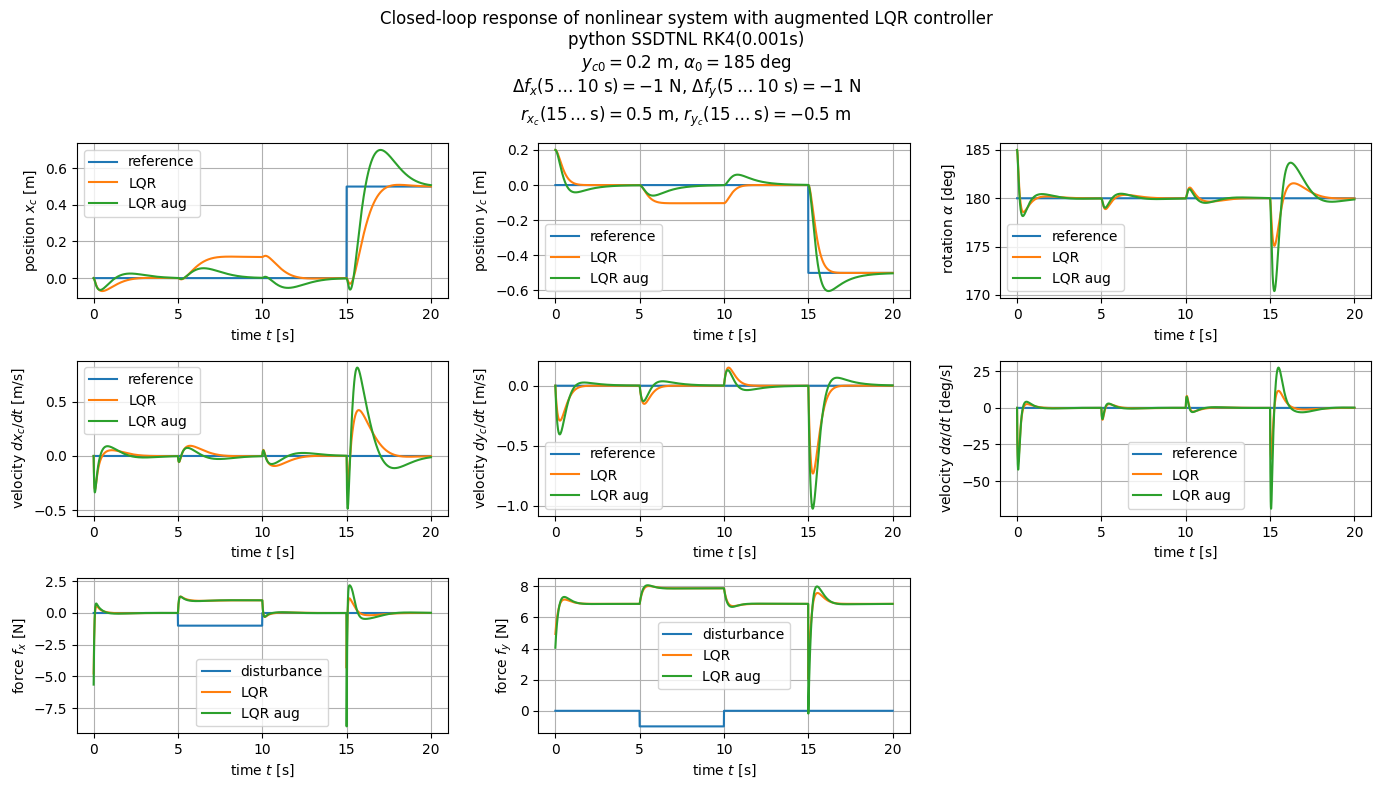

In [47]:
time_vector = np.arange(0, 20 + 1e-6, Ts)
reference_vector = np.zeros((6, time_vector.shape[0]), dtype=np.float64)
reference_vector[2, :] = np.pi  # ra
reference_vector[0, int(15 / Ts) :] = 0.5  # rxc = 0.5m from 15s
reference_vector[1, int(15 / Ts) :] = -0.5  # ryc = -0.5m from 15s
disturbance_vector = np.zeros((2, time_vector.shape[0]), dtype=np.float64)
disturbance_vector[0, int(5 / Ts) : int(10 / Ts)] = -1  # dfx = -1N from 5s to 10s
disturbance_vector[1, int(5 / Ts) : int(10 / Ts)] = -1  # dfy = -1N from 5s to 10s

sim_lqr_aug_2 = control.input_output_response(
    sys=closed_loop_aug,
    T=time_vector,
    U=np.vstack([reference_vector, disturbance_vector]),  # type: ignore
    X0=np.hstack([x0, np.zeros((2,))]) + np.array([0, 0.2, math.radians(5), 0, 0, math.radians(0), 0, 0]),  # type: ignore
)
sim_lqr_aug_2.y[6:8] = sim_lqr_aug_2.y[6:8] + u0[:, np.newaxis]  # !!!

plt.figure(figsize=(14, 8))
plot2(sim_lqr_aug_2.t, *[None] * 6, f_x=disturbance_vector[0], f_y=disturbance_vector[1], label="disturbance")
plot(sim_lqr_aug_2.t, *reference_vector, label="reference", rows=3)
plot2(sim_lqr_2.t, *sim_lqr_2.y, label="LQR")
plot2(sim_lqr_aug_2.t, *sim_lqr_aug_2.y, label="LQR aug")
plt.suptitle(
    (
        "Closed-loop response of nonlinear system with augmented LQR controller"
        "\n"
        "python SSDTNL RK4(0.001s)"
        "\n"
        r"$y_{c0} = 0.2$ m, $\alpha_0 = 185$ deg"
        "\n"
        r"$\Delta f_x(5 \dots 10\ \text{s}) = -1$ N, $\Delta f_y(5 \dots 10\ \text{s}) = -1$ N"
        "\n"
        r"$r_{x_c}(15 \dots \text{s}) = 0.5$ m, $r_{y_c}(15 \dots \text{s}) = -0.5$ m"
    )
)
plt.tight_layout()
plt.show()

del time_vector, reference_vector, disturbance_vector

# 5) MPC Design

https://jurajlieskovsky.github.io/OPCS2025/MPC-Direct.html

$$
\begin{aligned}
\min_{\mathbf{x}, \mathbf{u}}& \quad \mathbf{e}_N^T \mathbf{S} \mathbf{e}_N + \sum_{k = 0}^{N - 1} \left( \mathbf{e}_k^T \mathbf{Q} \mathbf{e}_k + \Delta\mathbf{u}_k^T \mathbf{R} \Delta\mathbf{u}_k \right) \\
\text{s. t.}& \quad \mathbf{x}_{k + 1} = \mathbf{A} \mathbf{x}_k + \mathbf{B} \mathbf{u}_k \\
& \quad \mathbf{e}_k = \mathbf{r}_k - \mathbf{x}_k \\
& \quad \Delta\mathbf{u}_k = \mathbf{u}_k - \mathbf{u}_{k - 1} \\
& \quad \mathbf{u}_\text{min} \leq \mathbf{u}_k \leq \mathbf{u}_\text{max} \\
& \quad \mathbf{S} \succeq 0, \quad \mathbf{Q} \succeq 0, \quad \mathbf{R} \succ 0
\end{aligned}
$$

In [48]:
def create_mpc(
    A: npt.NDArray[np.float64],
    B: npt.NDArray[np.float64],
    S: npt.NDArray[np.float64],
    Q: npt.NDArray[np.float64],
    R: npt.NDArray[np.float64],
    N: int,
    n: int,
    m: int,
):

    # Check matrix dimensions
    assert A.shape == (n, n)
    assert B.shape == (n, m)
    assert S.shape == (n, n)
    assert Q.shape == (n, n)
    assert R.shape == (m, m)

    #      x = [ x_{0}, x_{1}, ...,  x_{N-1}, x_{N} ]
    #      u = [ u_{0}, u_{1}, ...,  u_{N-1}        ]
    #      r = [        r,     ...,  r,       r     ]
    #      e = [        e_{1}, ...,  e_{N-1}, e_{N} ]
    # x_init = [ x_{0}                              ]

    # Define variables and parameters
    x = cp.Variable((n, N + 1), name="x")
    u = cp.Variable((m, N), name="u")
    r = cp.Parameter((n, 1), name="r")
    x_init = cp.Parameter(n, name="x_init")
    u_min = cp.Parameter((m, 1), name="u_min")
    u_max = cp.Parameter((m, 1), name="u_max")
    e = r - x[:, 1:]
    du = u[:, 1:] - u[:, :-1]

    # Define cost function and constraints
    cost = (
        cp.sum_squares(np.sqrt(S) @ e[:, -1])  # e_{N}^T @ S @ e_{N}
        + cp.sum_squares(np.sqrt(Q) @ e[:, :-1])  # e_{k}^T @ Q @ e_{k}
        + cp.sum_squares(np.sqrt(R) @ du)  # du_{k}^T @ R @ du_{k}
    )
    constraints = [
        x[:, 0] == x_init,  # x_{0} := x_init
        x[:, 1:] == A @ x[:, :-1] + B @ u,
        u_min <= u,
        u <= u_max,
    ]

    # Create the MPC problem
    mpc = cp.Problem(cp.Minimize(cost), constraints)
    print(f"{mpc.is_qp() = }")
    print(f"{mpc.is_dpp() = }")

    return (mpc, x_init, u_min, u_max, u, r)


Sim = namedtuple("Sim", ["t", "x", "u", "r", "d"])

## Simulations

mpc.is_qp() = True
mpc.is_dpp() = True


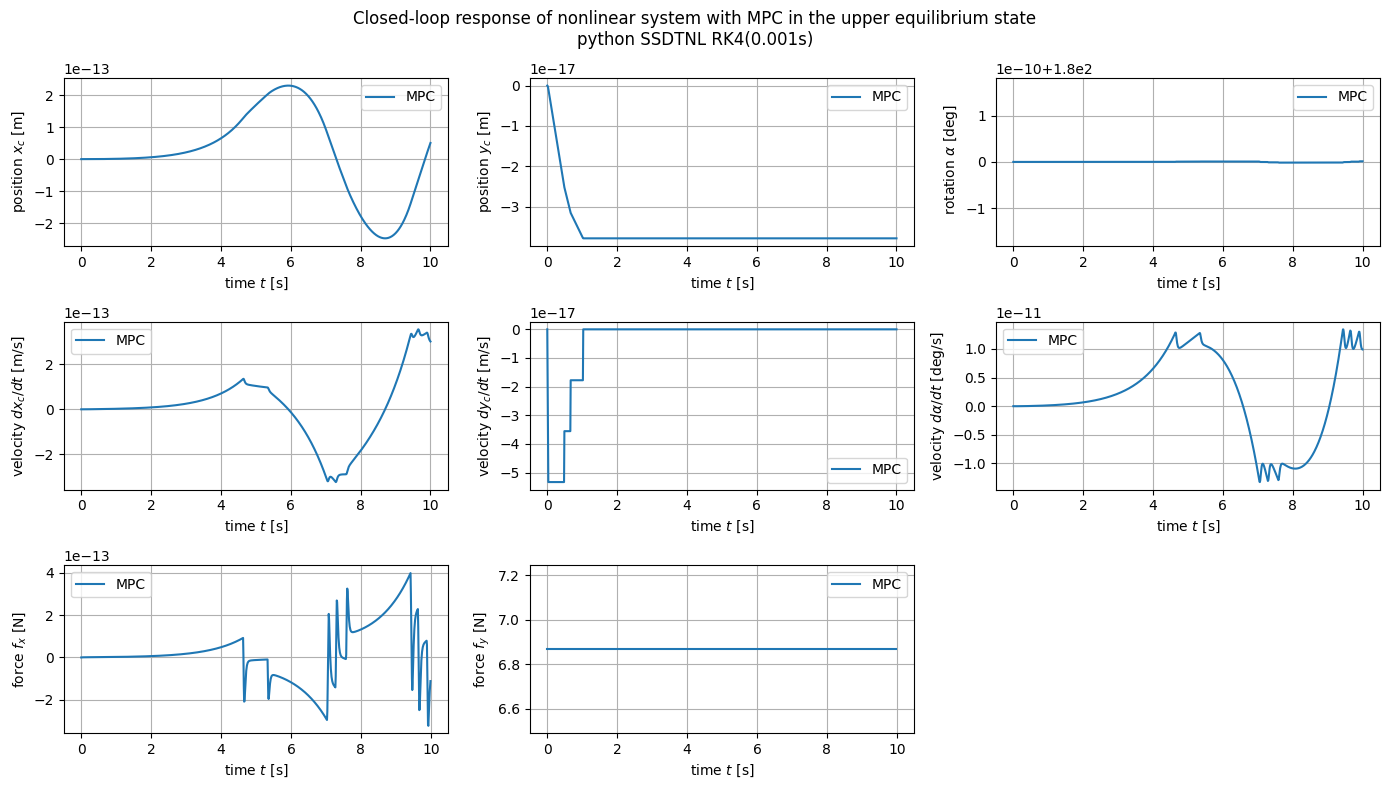

In [49]:
# Create the MPC problem
mpc, mpc_x_init, mpc_u_min, mpc_u_max, mpc_inputs, mpc_reference = create_mpc(
    A=SSDTL_model.A,  # type: ignore
    B=SSDTL_model.B,  # type: ignore
    S=np.diag([100, 100, 1000, 1, 1, 1]),
    Q=np.diag([10, 10, 100, 1, 1, 1]),
    R=np.diag([0.1, 0.1]),
    N=100,
    n=6,
    m=2,
)
mpc_u_min.value = np.array([-10, -10], dtype=np.float64)[:, np.newaxis]
mpc_u_max.value = np.array([10, 10], dtype=np.float64)[:, np.newaxis]
mpc_reference.value = np.array([0, 0, math.radians(0), 0, 0, math.radians(0)], dtype=np.float64)[:, np.newaxis]

# Create the simulation data
mpc_M = 1000
_ = Sim(
    t=np.arange(0, mpc_M * Ts + 1e-6, Ts),
    x=np.zeros((6, mpc_M + 1)),
    u=np.zeros((2, mpc_M)),
    r=None,
    d=None,
)
_.x[:, 0] = np.array([0, 0, math.radians(180), 0, 0, math.radians(0)], dtype=np.float64)

# Run the simulation
for i in range(mpc_M):
    mpc_x_init.value = _.x[:, i] - x0  # !!!
    mpc.solve(solver=cp.OSQP)
    _.u[:, i] = mpc_inputs.value[:, 0] + u0  # type: ignore  # !!!
    _.x[:, i + 1] = SSDTNL_model.dynamics(
        t=_.t[i],
        x=_.x[:, i],
        u=_.u[:, i],
    )

# Plot the results
plt.figure(figsize=(14, 8))
plot(_.t, *_.x, label="MPC", rows=3)
plot2(_.t[:-1], *[None] * 6, *_.u, label="MPC")
plt.suptitle(
    "Closed-loop response of nonlinear system with MPC in the upper equilibrium state" "\n" "python SSDTNL RK4(0.001s)"
)
plt.tight_layout()
plt.show()

del mpc, mpc_x_init, mpc_u_min, mpc_u_max, mpc_inputs, mpc_reference, mpc_M

mpc.is_qp() = True
mpc.is_dpp() = True


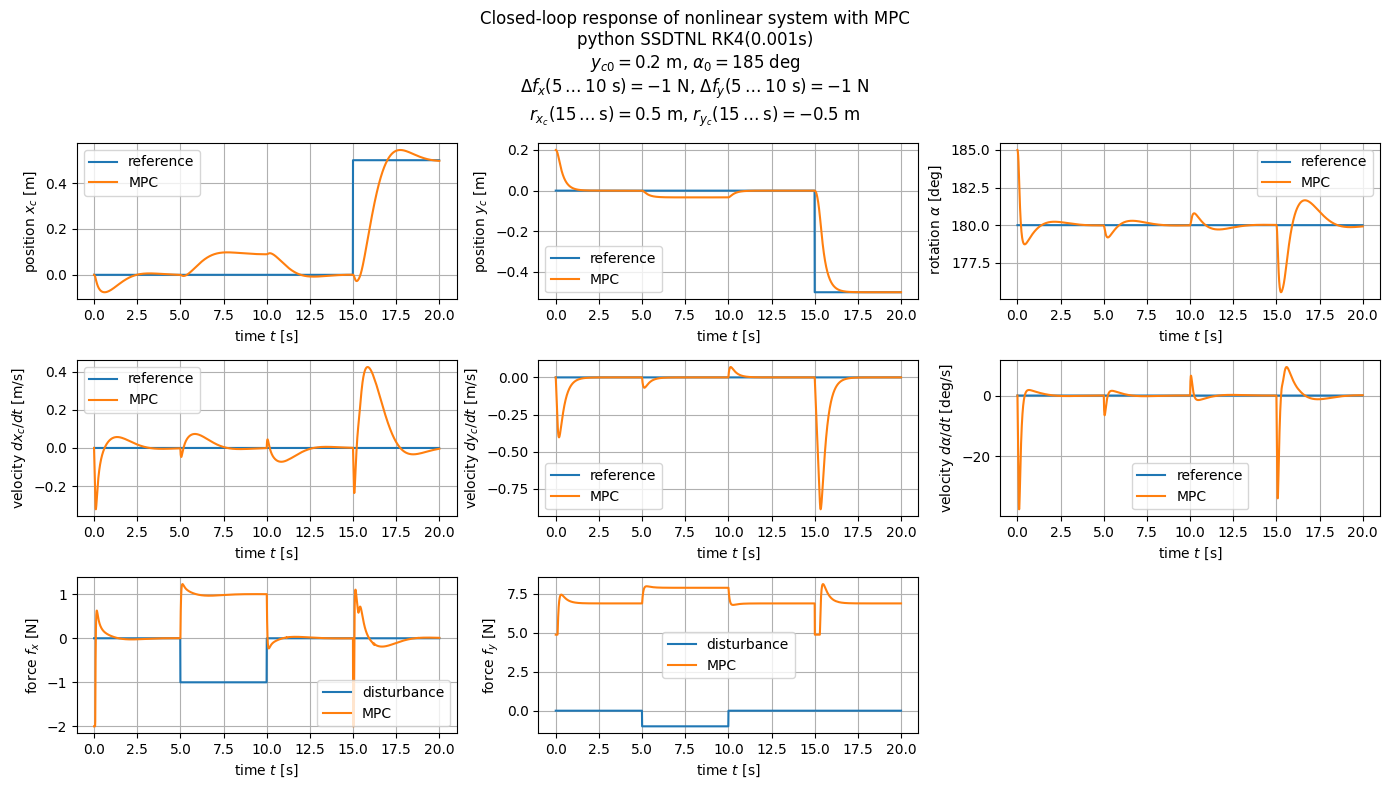

In [50]:
# Create the MPC problem
mpc, mpc_x_init, mpc_u_min, mpc_u_max, mpc_inputs, mpc_reference = create_mpc(
    A=SSDTL_model.A,  # type: ignore
    B=SSDTL_model.B,  # type: ignore
    S=np.diag([100, 100, 1000, 1, 1, 1]),
    Q=np.diag([10, 10, 100, 1, 1, 1]),
    R=np.diag([0.1, 0.1]),
    N=100,
    n=6,
    m=2,
)
mpc_u_min.value = np.array([-2, -2], dtype=np.float64)[:, np.newaxis]
mpc_u_max.value = np.array([2, 2], dtype=np.float64)[:, np.newaxis]

# Create the simulation data
mpc_M = 2000
sim_mpc_2 = Sim(
    t=np.arange(0, mpc_M * Ts + 1e-6, Ts),
    x=np.zeros((6, mpc_M + 1)),
    u=np.zeros((2, mpc_M)),
    r=np.zeros((6, mpc_M)),
    d=np.zeros((2, mpc_M)),
)
sim_mpc_2.x[:, 0] = np.array([0, 0.2, math.radians(185), 0, 0, math.radians(0)], dtype=np.float64)
sim_mpc_2.r[2, :] = np.pi  # ra
sim_mpc_2.r[0, int(15 / Ts) :] = 0.5  # rxc = 0.5m from 15s
sim_mpc_2.r[1, int(15 / Ts) :] = -0.5  # ryc = -0.5m from 15s
sim_mpc_2.d[0, int(5 / Ts) : int(10 / Ts)] = -1  # dfx = -1N from 5s to 10s
sim_mpc_2.d[1, int(5 / Ts) : int(10 / Ts)] = -1  # dfy = -1N from 5s to 10s

# Run the simulation
for i in range(mpc_M):
    mpc_x_init.value = sim_mpc_2.x[:, i] - x0  # !!!
    mpc_reference.value = (sim_mpc_2.r[:, i] - x0)[:, np.newaxis]  # !!!
    mpc.solve(solver=cp.OSQP)
    sim_mpc_2.u[:, i] = mpc_inputs.value[:, 0] + u0  # type: ignore  # !!!
    sim_mpc_2.x[:, i + 1] = SSDTNL_model.dynamics(
        t=sim_mpc_2.t[i],
        x=sim_mpc_2.x[:, i],
        u=sim_mpc_2.u[:, i] + sim_mpc_2.d[:, i],
    )

# Plot the results
plt.figure(figsize=(14, 8))
plot2(sim_mpc_2.t[:-1], *[None] * 6, f_x=sim_mpc_2.d[0], f_y=sim_mpc_2.d[1], label="disturbance")
plot(sim_mpc_2.t[:-1], *sim_mpc_2.r, label="reference", rows=3)
plot(sim_mpc_2.t, *sim_mpc_2.x, label="MPC", rows=3)
plot2(sim_mpc_2.t[:-1], *[None] * 6, *sim_mpc_2.u, label="MPC")
plt.suptitle(
    (
        "Closed-loop response of nonlinear system with MPC"
        "\n"
        "python SSDTNL RK4(0.001s)"
        "\n"
        r"$y_{c0} = 0.2$ m, $\alpha_0 = 185$ deg"
        "\n"
        r"$\Delta f_x(5 \dots 10\ \text{s}) = -1$ N, $\Delta f_y(5 \dots 10\ \text{s}) = -1$ N"
        "\n"
        r"$r_{x_c}(15 \dots \text{s}) = 0.5$ m, $r_{y_c}(15 \dots \text{s}) = -0.5$ m"
    )
)
plt.tight_layout()
plt.show()

del mpc, mpc_x_init, mpc_u_min, mpc_u_max, mpc_inputs, mpc_reference, mpc_M

In [51]:
mpc_simulations: T.List[T.Tuple[int, float, Sim]] = []
_horizons: T.List[int] = [50, 100]
_angles: T.List[float] = [5, 10, 15]

for _horizon, _angle in itertools.product(_horizons, _angles):
    print(f"horizon = {_horizon}, angle = {_angle}")

    # Create the MPC problem
    mpc, mpc_x_init, mpc_u_min, mpc_u_max, mpc_inputs, mpc_reference = create_mpc(
        A=SSDTL_model.A,  # type: ignore
        B=SSDTL_model.B,  # type: ignore
        S=np.diag([100, 100, 1000, 1, 1, 1]),
        Q=np.diag([10, 10, 100, 1, 1, 1]),
        R=np.diag([0.1, 0.1]),
        N=_horizon,
        n=6,
        m=2,
    )
    mpc_u_min.value = np.array([-2, -2])[:, np.newaxis]
    mpc_u_max.value = np.array([2, 2])[:, np.newaxis]
    mpc_reference.value = np.array([0, 0, math.radians(0), 0, 0, math.radians(0)])[:, np.newaxis]

    # Create the simulation data
    mpc_M = int(5 / Ts)  # 2 seconds
    _sim = Sim(
        t=np.arange(0, mpc_M * Ts + 1e-6, Ts),
        x=np.zeros((6, mpc_M + 1)),
        u=np.zeros((2, mpc_M)),
        r=None,
        d=None,
    )
    _sim.x[:, 0] = np.array([0, 0, math.radians(180 + _angle), 0, 0, math.radians(0)])

    # Run the simulation
    for i in range(mpc_M):
        mpc_x_init.value = _sim.x[:, i] - x0  # !!!
        mpc.solve(solver=cp.OSQP)
        if mpc_inputs.value is None:
            print("solver failed")
            _sim.x[:, i + 1 :] = np.nan
            _sim.u[:, i:] = np.nan
            break
        _sim.u[:, i] = mpc_inputs.value[:, 0] + u0  # type: ignore  # !!!
        _sim.x[:, i + 1] = SSDTNL_model.dynamics(
            t=_sim.t[i],
            x=_sim.x[:, i],
            u=_sim.u[:, i],
        )
        # Stop the sim if the angle offset is too large
        if abs(_sim.x[2, i + 1] - x0[2]) > math.radians(25):
            print("angle offset too large")
            _sim.x[:, i + 1 :] = np.nan
            _sim.u[:, i:] = np.nan
            break

    mpc_simulations.append((_horizon, _angle, _sim))
    del mpc, mpc_x_init, mpc_u_min, mpc_u_max, mpc_inputs, mpc_reference, mpc_M

horizon = 50, angle = 5
mpc.is_qp() = True
mpc.is_dpp() = True
horizon = 50, angle = 10
mpc.is_qp() = True
mpc.is_dpp() = True
horizon = 50, angle = 15
mpc.is_qp() = True
mpc.is_dpp() = True
horizon = 100, angle = 5
mpc.is_qp() = True
mpc.is_dpp() = True
horizon = 100, angle = 10
mpc.is_qp() = True
mpc.is_dpp() = True
horizon = 100, angle = 15
mpc.is_qp() = True
mpc.is_dpp() = True


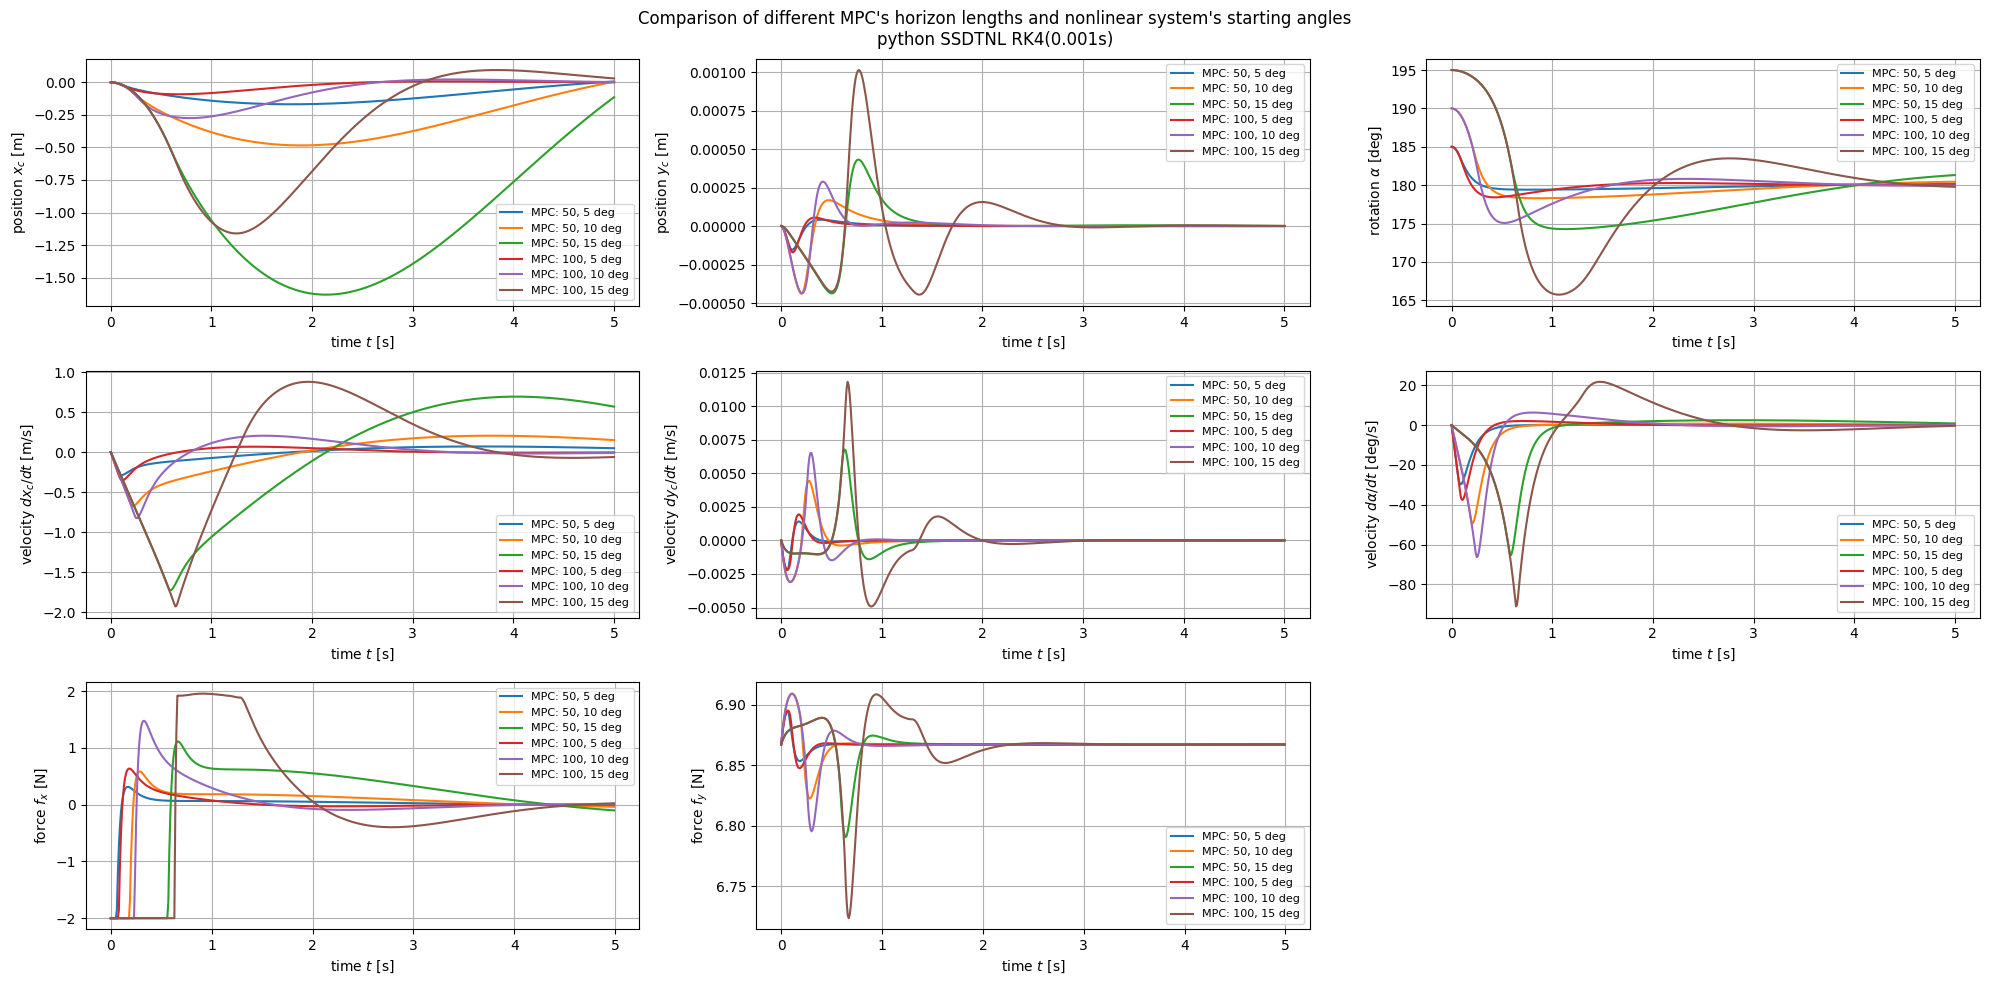

In [52]:
plt.figure(figsize=(20, 10))
for _horizon, _angle, sim in mpc_simulations:
    _label = f"MPC: {_horizon}, {_angle} deg"
    plot(sim.t, *sim.x, label=_label, rows=3)
    plot2(sim.t[:-1], *[None] * 6, *sim.u, label=_label)
for _ax in plt.gcf().axes:
    _ax.legend(fontsize=8)
plt.suptitle(
    (
        "Comparison of different MPC's horizon lengths and nonlinear system's starting angles"
        "\n"
        "python SSDTNL RK4(0.001s)"
    )
)
plt.tight_layout()
plt.show()

# 6) Simulations of Nonlinear System with LQR and MPC

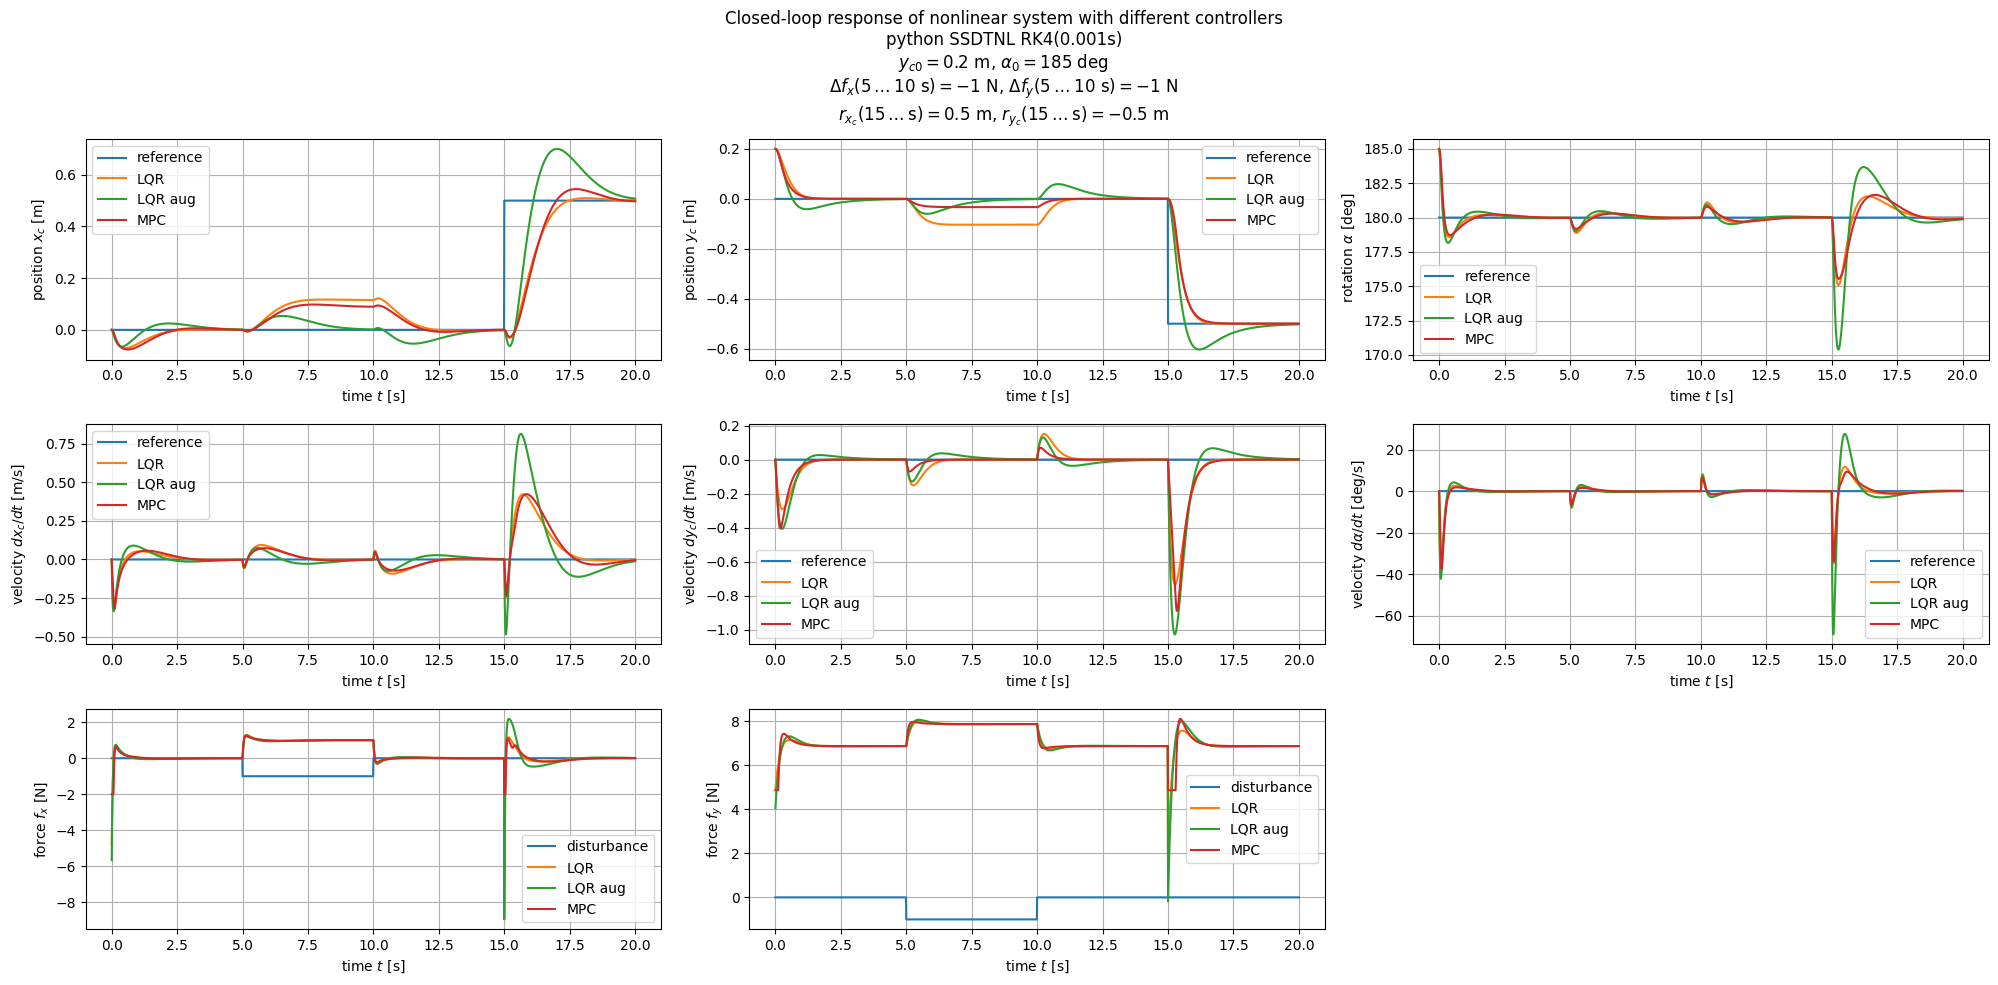

In [53]:
plt.figure(figsize=(20, 10))
# Disturbance and reference signals
plot2(sim_lqr_2.t, *[None] * 6, f_x=sim_lqr_2_d[0], f_y=sim_lqr_2_d[1], label="disturbance")
plot(sim_lqr_2.t, *sim_lqr_2_r, label="reference", rows=3)
# Classic LQR
plot2(sim_lqr_2.t, *sim_lqr_2.y, label="LQR")
# Augmented LQR
plot2(sim_lqr_aug_2.t, *sim_lqr_aug_2.y, label="LQR aug")
plt.suptitle(
    "Closed-loop response of nonlinear system with different controllers"
    "\n"
    "python SSDTNL RK4(0.001s)"
    "\n"
    r"$y_{c0} = 0.2$ m, $\alpha_0 = 185$ deg"
    "\n"
    r"$\Delta f_x(5 \dots 10\ \text{s}) = -1$ N, $\Delta f_y(5 \dots 10\ \text{s}) = -1$ N"
    "\n"
    r"$r_{x_c}(15 \dots \text{s}) = 0.5$ m, $r_{y_c}(15 \dots \text{s}) = -0.5$ m"
)
# MPC
plot(sim_mpc_2.t, *sim_mpc_2.x, label="MPC", rows=3)
plot2(sim_mpc_2.t[:-1], *[None] * 6, *sim_mpc_2.u, label="MPC")
plt.tight_layout()
plt.show()

# 7) Conclusion

In this project, I have:

1. modeled an inverted pendulum on a cart that moves in both the horizontal and vertical directions,
2. linearized the system,
3. designed classic infinite-horizon discrete-time LQR and its augmented version,
5. designed MPC,
6. simulated the nonlinear system with the different controllers.

From the observed behavior of the simulated controllers, I can conclude that:

1. classic LQR:
    - easy to design,
    - analytical methods exist to reason about stability and robustness,
    - optimal only for the linear model near the operating point,
    - requires state observers in real-world systems for full state feedback,
    - tunable only with the weights in Q and R matrices,
    - does not remove steady state error,
    - no easy way to set bounds on the control variables,
2. augmented LQR, same as classic except that:
    - has dynamics,
    - removes steady state error,
    - requires integrator anti-windup strategy,
    - harder to tune,
3. MPC:
    - wide range of formulations and cost functions,
    - viable for time-varying systems,
    - direct way to set bounds on the state/control variables,
    - harder to deal with steady state error,
    - requires linear model and convex cost function and constrains,
    - methods for nonlinear non-convex optimization available,
    - computationally intensive,
    - tunable with horizon length, cost function, constraints and weights in S, Q and R matrices,
    - requires state observers in real-world systems for full state feedback,
    - requires additional logic around it for real-world applications (solver failures, fallback, etc.),
    - non-intuitive effect of individual parameters.

For different simulation results, controller performance, solver performance or more informative data, the following can be changed/added:
- system/model properties (weights, lengths, damping, etc.),
- sampling time for model discretization,
- integration method,
- weighting matrices,
- MPC horizon length, formulation, cost function, constraints and solver,
- saturation of LQR output,
- anti-windup strategy,
- state observer (with modeled disturbance),
- noisy signals,
- measure settling times and overshoots,
- parameter and/or initial condition sweep.